In [1]:
%matplotlib inline

# ставим пипом то, чего нет
# ! pip install numpy==1.17
# ! pip install scipy==1.1.0
# ! pip install scikit-learn==0.21.3
# ! pip install matplotlib
# ! pip install pandas
# ! pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from scipy.spatial.distance import euclidean
from scipy.stats import norm, lognorm
from sklearn.model_selection import train_test_split 

In [41]:
data2017 = pd.read_csv("static/2017.csv")
data2018 = pd.read_csv("static/2018.csv")
data2019 = pd.read_csv("static/2019.csv")

In [ ]:
"""
ГИПОТЕЗЫ

1. Корреляции некоторых столбцов таблицы с целевым -> подтвердилось
2. Зависимость от географического положения -> подтвердилось
3. Природа распределения цены: нормальное -> не подтвердилось
4. Зависимость цены от даты продажи -> не подтвердилось
5. Зависимость цены от непараметрических признаков (новостройки и пр.) -> подтвердилось
6. Размер обучающих данных не сильно влияет на прогноз -> подтвердилось

ЧЁ СОБСНА ДЕЛАЕМ
1. Т.к. для обучения нужно не слишком много данных, то пропуски нужно просто дропать (готово)
2. Некоррелирующие столбцы модели просто не отдаем -> они её только сбивают (готово)
3. Надо посмотреть природу выбросов (хотя бы квартили) -> дропать нахер (готово)
4. Заменить широту и долготу на метрику удалённости от центра и использовать именно её (попробовал ->  говно)
5. Заменить непараметрические фичи (в конце блокнота) на константы и отдать классификатору (готово)
6. С параметрами модели я уже наигрался -> нужно просто дать ей чистые данные (готово)
"""

In [6]:
data2019.describe()

,number_of_rooms,total_floor_area,epc_energy_consumption_current,epc_lighting_cost_current,epc_heating_cost_current,epc_hot_water_cost_current,epc_flat_storey_count,epc_number_open_fireplaces,epc_floor_height,latitude,longitude,closeststop,crimesin3km_antisocial,closestschool,closestpark,address_id,distance_center
count,25775.000000,28323.000000,28323.000000,28323.000000,28323.000000,28323.000000,2606.000000,25850.000000,15239.000000,28321.000000,28321.000000,28052.000000,28320.000000,26890.000000,26364.000000,2.832300e+04,28321.000000
mean,4.482211,89.842777,1059.175123,77.230160,672.075178,137.459270,2.988872,0.211141,2.450256,52.344054,-1.378285,297.752091,2250.969880,464.329900,948.511569,9.418641e+07,6.097563
std,1.580803,58.958723,4812.350197,59.975968,452.811068,71.059309,2.073938,0.557207,0.273533,1.145298,1.335869,454.904724,2665.934581,400.751073,773.612523,3.329168e+06,7.058303
min,1.000000,1.240000,-30.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,49.987482,-5.691800,2.286049,0.000000,0.000000,13.000000,8.857593e+07,0.028571
25%,3.000000,65.000000,197.000000,54.000000,395.000000,94.000000,2.000000,0.000000,2.330000,51.444818,-2.248804,97.357629,474.000000,240.000000,408.000000,9.122862e+07,1.777685
50%,4.000000,81.000000,262.000000,71.000000,583.000000,114.000000,3.000000,0.000000,2.400000,52.201565,-1.415831,157.941862,1428.000000,375.000000,706.000000,9.411824e+07,3.732491
75%,5.000000,102.000000,348.000000,92.000000,818.000000,156.000000,4.000000,0.000000,2.520000,53.372771,-0.295174,281.528629,2939.250000,558.000000,1217.000000,9.710424e+07,7.662969
max,40.000000,6886.100000,182162.000000,8253.000000,9140.000000,961.000000,28.000000,11.000000,20.000000,55.777929,1.754483,4757.317580,21896.000000,4593.000000,4798.000000,9.999101e+07,80.603386


In [7]:
data2018.describe()

,price,number_of_rooms,total_floor_area,epc_energy_consumption_current,epc_lighting_cost_current,epc_heating_cost_current,epc_hot_water_cost_current,epc_flat_storey_count,epc_number_open_fireplaces,epc_floor_height,latitude,longitude,closeststop,crimesin3km_antisocial,closestschool,closestpark,address_id,distance_center
count,9.865650e+05,361287.000000,409595.000000,409595.000000,409595.000000,409595.000000,409595.000000,39583.000000,362585.000000,216794.000000,906888.000000,906888.000000,896594.000000,906668.000000,857402.000000,838429.000000,9.865650e+05,906888.000000
mean,3.453821e+05,4.506971,88.307018,1049.659930,77.419304,679.006654,138.278373,3.123765,0.201081,2.454311,52.365887,-1.379345,310.677958,2339.645078,481.820775,963.748329,9.940130e+07,6.168990
std,1.818853e+06,1.680315,51.231621,4979.396762,40.717142,521.660996,73.737421,2.412517,0.586876,0.552198,1.146690,1.325793,476.008688,2864.454167,431.092765,791.441957,5.677736e+06,7.203666
min,1.000000e+00,1.000000,0.000000,-229.000000,-1.000000,-801.000000,-1.000000,0.000000,0.000000,0.000000,49.913412,-6.318531,0.915098,0.000000,0.000000,5.000000,8.857593e+07,0.003302
25%,1.460000e+05,3.000000,63.000000,195.000000,54.000000,385.000000,94.000000,2.000000,0.000000,2.320000,51.460335,-2.254189,96.677427,453.000000,241.000000,413.000000,9.431985e+07,1.802819
50%,2.300000e+05,4.000000,80.000000,262.000000,71.000000,578.000000,114.000000,3.000000,0.000000,2.400000,52.223907,-1.420463,160.018906,1436.000000,380.000000,713.000000,1.003003e+08,3.759811
75%,3.550000e+05,5.000000,102.000000,350.000000,92.000000,825.000000,157.000000,4.000000,0.000000,2.520000,53.381303,-0.291268,292.025261,3031.000000,572.000000,1241.000000,1.053053e+08,7.691601
max,5.692000e+08,91.000000,3571.440000,416354.000000,5505.000000,62707.000000,1411.000000,63.000000,75.000000,204.000000,55.797415,1.758397,4815.169126,23074.000000,4743.000000,4786.000000,1.056136e+08,83.567883


In [8]:
data2017.describe()

,price,number_of_rooms,total_floor_area,epc_energy_consumption_current,epc_lighting_cost_current,epc_heating_cost_current,epc_hot_water_cost_current,epc_flat_storey_count,epc_number_open_fireplaces,epc_floor_height,latitude,longitude,closeststop,crimesin3km_antisocial,closestschool,closestpark,address_id,distance_center
count,9.922120e+05,488846.000000,550761.000000,550761.000000,550761.000000,550761.000000,550761.000000,46374.000000,490416.000000,308738.000000,981289.000000,981289.000000,970311.000000,981030.000000,929846.000000,907947.000000,9.922120e+05,981289.000000
mean,3.430209e+05,4.607099,91.285681,932.934124,80.054866,718.063476,142.841696,3.207465,0.200783,2.452155,52.340786,-1.353508,311.753490,2371.478555,485.204683,964.415709,9.772327e+07,6.210879
std,2.057961e+06,1.765542,54.153310,4616.730188,40.891643,552.759957,76.631545,2.540377,0.561604,0.640488,1.141627,1.329082,475.290107,2943.331264,432.445959,793.564470,4.938171e+06,7.306605
min,1.000000e+00,1.000000,0.000000,-1323.000000,-8.000000,-65.000000,-31.000000,0.000000,0.000000,0.000000,49.913207,-6.352647,0.532170,0.000000,0.000000,3.000000,8.857598e+07,0.003302
25%,1.400000e+05,3.000000,64.000000,196.000000,55.000000,401.000000,96.000000,2.000000,0.000000,2.330000,51.455900,-2.240896,96.812114,446.000000,243.000000,412.000000,9.336849e+07,1.791768
50%,2.248145e+05,4.000000,81.500000,262.000000,73.000000,606.000000,117.000000,3.000000,0.000000,2.400000,52.143151,-1.387420,161.098046,1430.000000,383.000000,712.000000,9.830963e+07,3.749439
75%,3.500000e+05,5.000000,105.300000,348.000000,96.000000,872.000000,164.000000,4.000000,0.000000,2.500000,53.364162,-0.258715,295.766537,3048.000000,576.000000,1241.000000,1.021145e+08,7.717438
max,7.075042e+08,90.000000,5327.890000,358454.000000,6760.000000,48391.000000,1395.000000,55.000000,50.000000,230.000000,55.797415,1.757928,4784.667983,23074.000000,4695.000000,4838.000000,1.056134e+08,83.744964


In [ ]:
# есть некоторые выбросы, которы можно задетектить в max и min значениях
# и исключить

In [7]:
print("Тестирование depth:")
for i in range(1, 10):
    model = CatBoostRegressor(learning_rate=1, depth=i, loss_function='Quantile', verbose=False)
    model.fit(train_data, train_labels)
    preds = model.predict(eval_data)

    print(i, np.median(abs(preds - eval_labels['price']) / preds))

Тестирование learning_rate:
[212387.69925788 161679.80826094  78052.84175399 ... 297462.89548972
 373656.88734343 122350.92698958]
1 0.24345404859112094
[172539.53761732 161664.51803672 102268.98553491 ... 285105.38986291
 264259.64795324  91340.8491447 ]
2 0.19405069295020752
[206364.55833011 164697.84982212  69328.0248193  ... 318388.22307308
 241121.38837114 129529.92665279]
3 0.1817605119676515
[221655.02712026 149718.47590936  74439.25872413 ... 316271.04979497
 215005.15888383 143664.77578442]
4 0.17537112538150695
[253497.3708117  133094.86973222  61560.19160973 ... 281406.30348188
 223274.46736619 146434.01807359]
5 0.17169906072512603
[207704.24778599 158026.97366208  57425.27173882 ... 301911.97718661
 248981.28800611 128016.8400262 ]
6 0.1693051680039298
[244427.45571227 142450.27211043  76561.61165293 ... 299708.63609629
 243487.29311146 124183.64233864]
7 0.16893567116865751
[227037.28278151 128494.16823647  50777.475581   ... 300093.80334756
 249089.53828503 160819.795376

In [8]:
print("Тестирование learning_rate:")
for i in range(1, 11):
    model = CatBoostRegressor(learning_rate=i/10, depth=6, loss_function='Quantile', verbose=False)
    model.fit(train_data, train_labels)

    preds = model.predict(eval_data)

    print(i/10, np.median(abs(preds - eval_labels['price']) / preds))

Тестирование learning_rate:
[196732.88518916 144087.90480538  80694.83012026 ... 296047.62659941
 226725.88031519 124467.37829796]
1 0.17400450102171675
[206408.67061721 137870.68138563  75584.08169368 ... 299164.54982763
 218901.89424626 123507.72804143]
2 0.16825745589493757
[207875.69852644 130784.84504359  64993.67012585 ... 313424.68026312
 208336.34717616 120903.79580296]
3 0.166180568899069
[215130.32006265 131765.63741484  64980.1692473  ... 296939.33585143
 239480.28183636 144134.8443949 ]
4 0.1653238288268244
[226981.97512532 129894.47390955  61860.88901662 ... 287388.97585755
 224837.42104037 131910.30250301]
5 0.16556825685915647
[220824.64204493 124762.85684798  68493.60901233 ... 299646.35053174
 220951.61366595 121344.85006737]
6 0.16643891355631302
[214963.6153657  133330.37453875  47966.36535836 ... 280066.21973048
 229911.93290477 124591.02729682]
7 0.16628941765560434
[234480.80523413 137803.39800927  62480.51881908 ... 293265.63677557
 258617.24119693 137373.4729010

In [20]:
# сохраняем в CSV вот так
df = pd.DataFrame.from_records({'transaction_id': eval_labels.values.reshape(eval_labels.values.shape[0], ), 
                                'price': preds.reshape(preds.shape[0], )}, index='transaction_id')
print(df.head())

df.to_csv('data.csv') 

In [4]:
# корреляционный анализ
#
# наблюдаем наличие слабой корреляции цены с колонками
# 'number_of_rooms rows', 'total_floor_area rows',
# 'epc_lighting_cost_current', 'epc_heating_cost_current',
# 'epc_number_open_fireplaces', 'crimesin3km_antisocial',
# 'epc_flat_storey_count'
#
# прочие колонки можем спокойно дропать

groups = data2017.columns.to_series().groupby(data2017.dtypes).groups
for key in groups:
    if key != np.sctypeDict["object"]:
        for col in groups[key]:            
            d = data2018.dropna(subset=[col])

            a = d['price']
            b = d[col]

            print(col, "rows:", len(d))
            print(np.corrcoef(a, b)[0, 1])
    

price rows: 986565
0.9999999999999999
address_id rows: 986565
0.029587567010435217
number_of_rooms rows: 361287
0.18757892792792807
total_floor_area rows: 409595
0.18907660767598156
epc_energy_consumption_current rows: 409595
0.018242073603866663
epc_lighting_cost_current rows: 409595
0.15769370373353553
epc_heating_cost_current rows: 409595
0.12487115299948241
epc_hot_water_cost_current rows: 409595
0.03227808858996808
epc_flat_storey_count rows: 39583
0.07526449718447296
epc_number_open_fireplaces rows: 362585
0.09972617947351622
epc_floor_height rows: 216794
0.020298414612969447
latitude rows: 906888
-0.05326185045657343
longitude rows: 906888
0.04579215021213316
closeststop rows: 896594
-0.0015546902471288144
crimesin3km_antisocial rows: 906668
0.08256380723283005
closestschool rows: 857402
0.013584648797665444
closestpark rows: 838429
-0.010433476112320584
distance_center rows: 906888
-0.017872673034673582


mean: 345382.0577569648
std: 1818852.1625287859


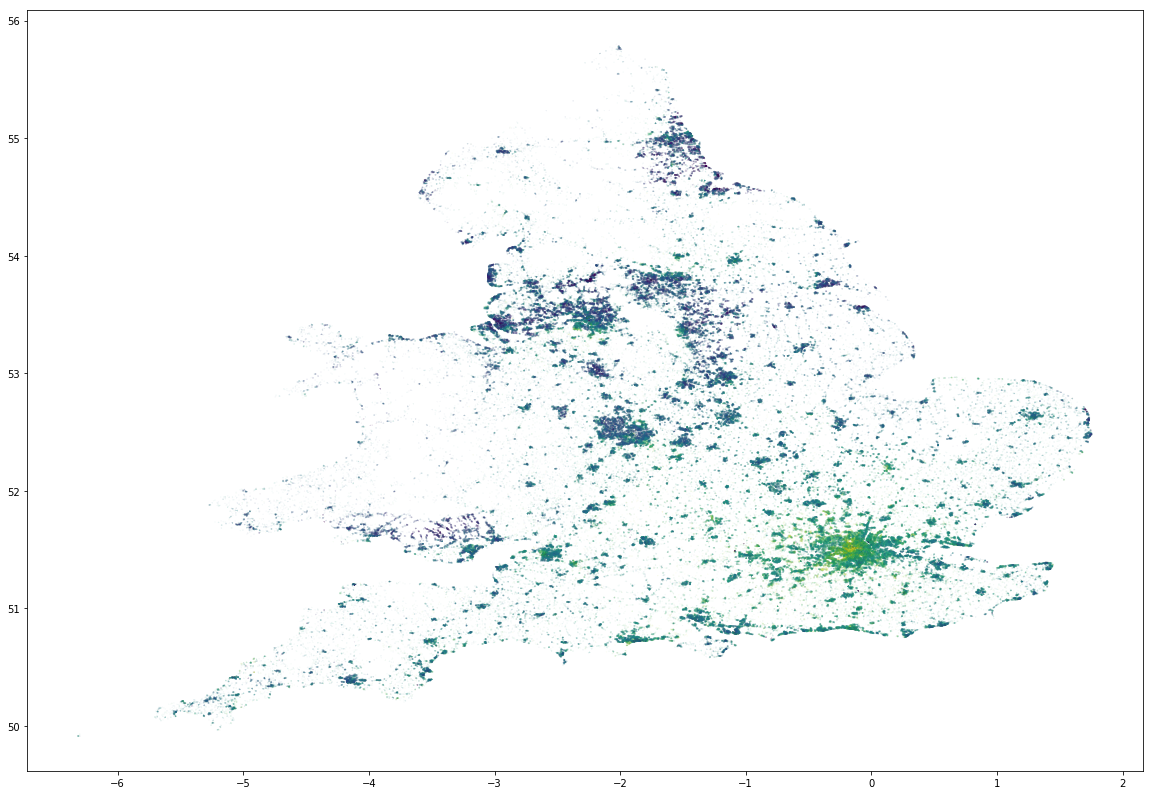

In [59]:
x = data2018['longitude'].values
y = data2018['latitude'].values
z = data2018['price'].values

mean = np.mean(z)
std = np.std(z)

print("mean:", mean)
print("std:", std)
  
colors = np.array(list(map(colorize, z)))

plt.scatter(x, y, c=colors, s=0.01, alpha=0.2, cmap='viridis')
plt.rcParams["figure.figsize"] = (20, 14)
plt.show()

# вывод: есть дорогие районы
# (приблизительно в окресности точки (-0.2, 51.5))
# значит, нужно ввести метрику удалённости от них

[0.2 0.8 0.5 ... 0.2 0.6 0.4]


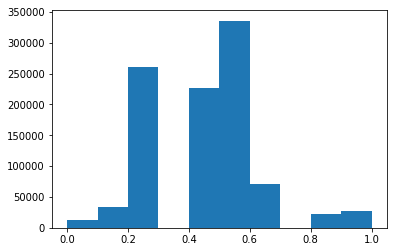

In [20]:
print(colors)
plt.hist(colors)
plt.show()
# вывод: распределение далеко от нормального
# + есть странный "провал" в ценовой категории

In [76]:
from datetime import datetime

def fix_date(elem):
    return (datetime.strptime(elem, "%Y-%m-%d")).timestamp()

data = data2017[["created", "price"]]
data = data.dropna()
dates = data["created"].values
prices = data["price"].values

datetimes = np.array(list(map(fix_date, dates)))
print(datetimes)

[1.4980644e+09 1.5078276e+09 1.4889060e+09 ... 1.4854500e+09 1.4836356e+09
 1.5072228e+09]


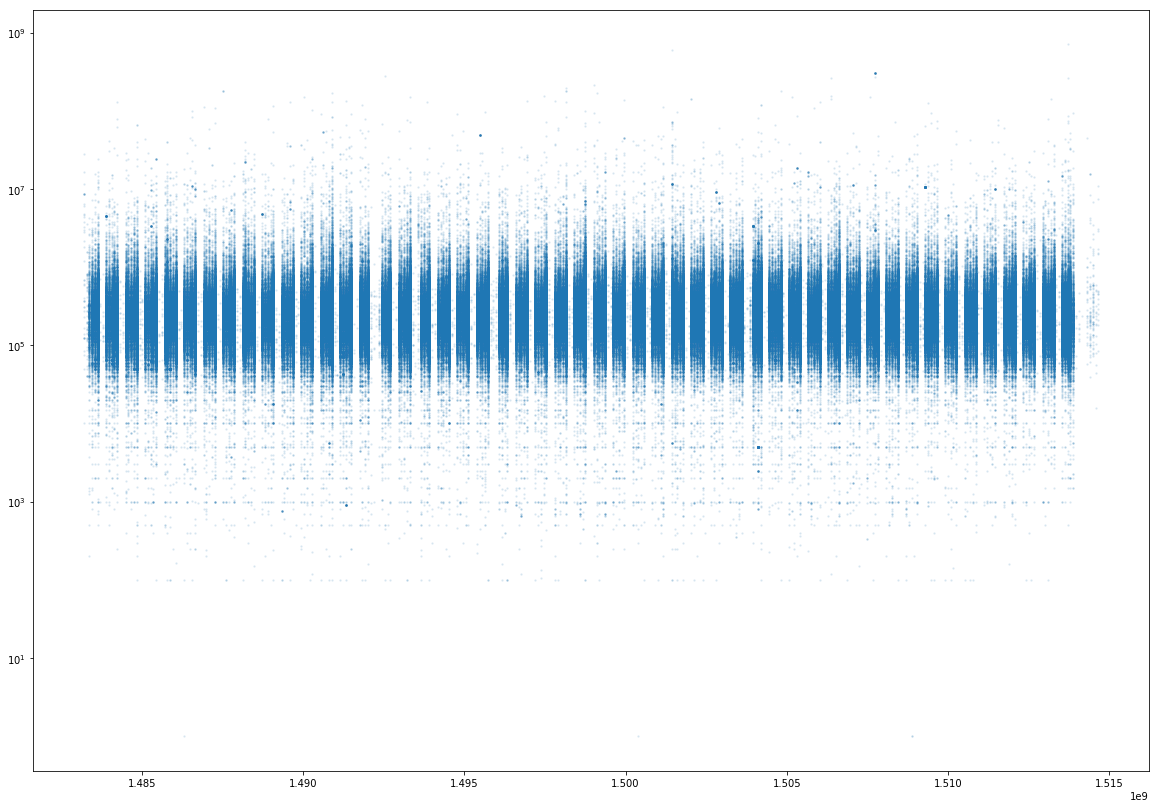

In [77]:
y = np.array(list(map(colorize, prices)))

plt.scatter(datetimes, prices, s=2, alpha=0.1)
plt.rcParams["figure.figsize"] = (20, 14)
plt.yscale('log')
plt.show()

# ну тут можно сказать только то, что в одни дни было больше продаж, чем в другие

In [ ]:
# дальше я тупо смотрю на непараметрические данные

In [78]:
new = data2017.loc[data2017['old_new'] == 'Y']
old = data2017.loc[data2017['old_new'] == 'N']

new_prices = new["price"].values
old_prices = old["price"].values

print("New prices mean:", np.mean(new_prices))
print("Old prices mean:", np.mean(old_prices))

print("New prices median:", np.median(new_prices))
print("Old prices median:", np.median(old_prices))

print("New prices std:", np.std(new_prices))
print("Old prices std:", np.std(old_prices))

# вывод: медианная цена старых построек и новостроек примерно равна
# но у старых зданий значительно выше дисперсия (что логично)
# следовательно, у новостроек в пропущенные данные можно попробовать ставить средние значения по выборке
# (потому что они примерно одинаковые в одних и тех же районах)

New prices mean: 336329.07739114517
Old prices mean: 343711.73949001456
New prices median: 274500.0
Old prices median: 218500.0
New prices std: 389710.472523107
Old prices std: 2157955.3332843794


In [6]:
f = data2018.loc[data2018['duration'] == 'F']
l = data2018.loc[data2018['duration'] == 'L']

f_prices = f["price"].values
l_prices = l["price"].values

print("F prices mean:", np.mean(f_prices))
print("L prices mean:", np.mean(l_prices))

print("F prices median:", np.median(f_prices))
print("L prices median:", np.median(l_prices))

print("F prices std:", np.std(f_prices))
print("L prices std:", np.std(l_prices))

# вывод: ну, в целом, тоже можно преобразовать в нули и единицы и отдать в классификатор
# тут видно, что L несколько дешевле
# не думаю, что это сильно ему поможет, но CatBoost явно умнее меня

F prices mean: 352297.6396393051
L prices mean: 322948.39979781903
F prices median: 240000.0
L prices median: 190000.0
F prices std: 1683151.804336195
L prices std: 2202079.7366599217


In [30]:
d = data2018.groupby(['property_type'])['property_type'].unique().values

for elem in d:
    print(elem)
    c = data2018.loc[data2018['property_type'] == elem[0]]
    
    prices = c["price"].values
    
    print("num:", len(prices))
    print("prices mean:", np.mean(prices))
    print("prices median:", np.median(prices))
    print("prices std:", np.std(prices))
    
# вывод: очень полезная фича для классификации цены

['D']
num: 228195
prices mean: 405253.40686255175
prices median: 330000.0
prices std: 351141.38456510875
['F']
num: 171224
prices mean: 301824.8172686072
prices median: 210999.5
prices std: 612591.4700220202
['O']
num: 55141
prices mean: 1203989.0660488566
prices median: 250000.0
prices std: 7436562.36620762
['S']
num: 261702
prices mean: 252984.8224889378
prices median: 205000.0
prices std: 217946.00776318414
['T']
num: 270303
prices mean: 236732.8554030107
prices median: 175000.0
prices std: 480099.7690725138


In [ ]:
# с этого момента начинаю скармливать модели подготовленные данные

In [12]:
def preprocess(data):
    data['duration'] = data['duration'].map({'F': 1, 'L': 0})
    data['old_new'] = data['old_new'].map({'Y': 1, 'N': 0})
    data['property_type'] = data['property_type'].map({'O': None, 'D': 6, 'F': 3, 'S': 2, 'T': 0})
    
    return data

def better_preprocess(data):
    data['duration'] = data['duration'].map({'F': 1, 'L': 0})
    data['old_new'] = data['old_new'].map({'Y': 1, 'N': 0})
    data['property_type'] = data['property_type'].map({'O': None, 'D': 6, 'F': 3, 'S': 2, 'T': 0})
    data['longitude'] = data['longitude'].map(lambda x: int(x*100)/100)
    data['latitude'] = data['latitude'].map(lambda x: int(x*100)/100)
    
    return data

def bounds_check(data, standart):
    print("Before check:", len(data))
    groups = data.columns.to_series().groupby(data.dtypes).groups
    for key in groups:
        if key != np.sctypeDict["object"]:
            for col in groups[key]: 
                if col != 'price':
                    Max = standart[col].max()
                    Min = standart[col].min()
                    print(col, Max, Min)
                    indexNames = data[(data[col] < Min/2) | (data[col] > Max*1.5)].index
                    
                    data.drop(indexNames , inplace=True)
                    
    print("Remained:", len(data))

    return data

In [5]:
# тестовый блок
train_columns = [
    'number_of_rooms', 'total_floor_area',
    'epc_number_open_fireplaces', 'latitude', 'longitude',
    'duration', 'property_type', 'crimesin3km_antisocial',
    'epc_lighting_cost_current', 'epc_heating_cost_current'
]
target = ['price']

data2017 = pd.read_csv("static/2017.csv")
data2018 = pd.read_csv("static/2018.csv")
data2019 = pd.read_csv("static/2019.csv")

bounds_check(data2018, data2019)
bounds_check(data2017, data2019)

data2 = data2018.dropna(subset=train_columns)
data = data2017.dropna(subset=train_columns)

data2 = better_preprocess(data2)
data = better_preprocess(data)

frames = [data, data2]
result = pd.concat(frames)

train_data, eval_data, train_labels, eval_labels = train_test_split(result[train_columns], result[target], test_size=0.2, random_state = 0) 

print("Train size:", len(train_data))
print("Eval size:", len(eval_data))

train_data.head()

Before check: 986565
address_id 99991012 88575934
number_of_rooms 40.0 1.0
total_floor_area 6886.1 1.24
epc_energy_consumption_current 182162.0 -30.0
epc_lighting_cost_current 8253.0 -1.0
epc_heating_cost_current 9140.0 -1.0
epc_hot_water_cost_current 961.0 -1.0
epc_flat_storey_count 28.0 0.0
epc_number_open_fireplaces 11.0 0.0
epc_floor_height 20.0 0.0
latitude 55.777929 49.987482
longitude 1.7544830000000002 -5.6918
closeststop 4757.31758018 2.28604853
crimesin3km_antisocial 21896.0 0.0
closestschool 4593.0 0.0
closestpark 4798.0 13.0
distance_center 80.6033863765318 0.0285705819993504
Remained: 849923
Before check: 992212
address_id 99991012 88575934
number_of_rooms 40.0 1.0
total_floor_area 6886.1 1.24
epc_energy_consumption_current 182162.0 -30.0
epc_lighting_cost_current 8253.0 -1.0
epc_heating_cost_current 9140.0 -1.0
epc_hot_water_cost_current 961.0 -1.0
epc_flat_storey_count 28.0 0.0
epc_number_open_fireplaces 11.0 0.0
epc_floor_height 20.0 0.0
latitude 55.777929 49.987482
lon

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Train size: 584611
Eval size: 146153


,number_of_rooms,total_floor_area,epc_number_open_fireplaces,latitude,longitude,duration,property_type,crimesin3km_antisocial,epc_lighting_cost_current,epc_heating_cost_current
937198,4.0,69.160,0.0,53.50,-2.19,1,0.0,6878.0,32.977795,422.20984
509155,5.0,126.000,0.0,51.46,-0.28,1,2.0,2121.0,132.000000,1588.00000
140998,5.0,110.450,0.0,51.01,-0.08,1,0.0,385.0,100.000000,455.00000
189607,4.0,113.000,1.0,52.27,-1.58,1,0.0,1226.0,132.000000,867.00000
190024,3.0,68.188,0.0,52.51,-1.44,1,0.0,2272.0,57.000000,394.00000


In [6]:
model = CatBoostRegressor(learning_rate=0.3, depth=7, loss_function='MAE', 
                          iterations=13000, silent=False) # можно настроить verbosity
model.fit(train_data, train_labels)

preds = model.predict(eval_data)
print(model.get_feature_importance())

0:	learn: 136345.2568519	total: 188ms	remaining: 40m 48s
1:	learn: 120627.9815774	total: 299ms	remaining: 32m 20s
2:	learn: 110139.9544860	total: 418ms	remaining: 30m 10s
3:	learn: 102590.6662159	total: 546ms	remaining: 29m 34s
4:	learn: 98235.6777340	total: 655ms	remaining: 28m 22s
5:	learn: 93803.3472951	total: 760ms	remaining: 27m 24s
6:	learn: 90701.9925218	total: 877ms	remaining: 27m 8s
7:	learn: 89469.6644261	total: 985ms	remaining: 26m 39s
8:	learn: 87770.9003763	total: 1.09s	remaining: 26m 16s
9:	learn: 86063.4162418	total: 1.2s	remaining: 25m 53s
10:	learn: 84825.6602966	total: 1.3s	remaining: 25m 31s
11:	learn: 84095.6949915	total: 1.4s	remaining: 25m 13s
12:	learn: 83484.2660459	total: 1.5s	remaining: 24m 59s
13:	learn: 82651.8844177	total: 1.61s	remaining: 24m 53s
14:	learn: 82243.0830356	total: 1.71s	remaining: 24m 42s
15:	learn: 81993.4392859	total: 1.81s	remaining: 24m 33s
16:	learn: 81633.6303363	total: 1.92s	remaining: 24m 26s
17:	learn: 81196.2134937	total: 2.04s	rema

144:	learn: 68957.6065070	total: 15.9s	remaining: 23m 28s
145:	learn: 68925.2280878	total: 16s	remaining: 23m 28s
146:	learn: 68903.0724753	total: 16.1s	remaining: 23m 27s
147:	learn: 68766.4500085	total: 16.2s	remaining: 23m 29s
148:	learn: 68743.9826623	total: 16.3s	remaining: 23m 29s
149:	learn: 68725.9716696	total: 16.4s	remaining: 23m 29s
150:	learn: 68708.0490312	total: 16.6s	remaining: 23m 29s
151:	learn: 68682.9153416	total: 16.7s	remaining: 23m 30s
152:	learn: 68665.1630064	total: 16.8s	remaining: 23m 30s
153:	learn: 68617.4559659	total: 16.9s	remaining: 23m 29s
154:	learn: 68574.0343745	total: 17s	remaining: 23m 29s
155:	learn: 68537.7202015	total: 17.1s	remaining: 23m 30s
156:	learn: 68514.4848874	total: 17.2s	remaining: 23m 30s
157:	learn: 68492.8243535	total: 17.4s	remaining: 23m 31s
158:	learn: 68436.6161634	total: 17.5s	remaining: 23m 30s
159:	learn: 68423.3851537	total: 17.6s	remaining: 23m 30s
160:	learn: 68398.7094199	total: 17.7s	remaining: 23m 29s
161:	learn: 68376.

286:	learn: 65456.0114722	total: 31.7s	remaining: 23m 24s
287:	learn: 65443.2391384	total: 31.8s	remaining: 23m 23s
288:	learn: 65434.3412690	total: 31.9s	remaining: 23m 23s
289:	learn: 65430.6081165	total: 32s	remaining: 23m 23s
290:	learn: 65423.8473256	total: 32.1s	remaining: 23m 23s
291:	learn: 65371.2285158	total: 32.2s	remaining: 23m 22s
292:	learn: 65353.2731360	total: 32.3s	remaining: 23m 21s
293:	learn: 65328.2555889	total: 32.4s	remaining: 23m 21s
294:	learn: 65322.8583225	total: 32.5s	remaining: 23m 21s
295:	learn: 65305.3549521	total: 32.6s	remaining: 23m 20s
296:	learn: 65303.0805919	total: 32.8s	remaining: 23m 20s
297:	learn: 65288.4409424	total: 32.9s	remaining: 23m 20s
298:	learn: 65256.4578663	total: 33s	remaining: 23m 19s
299:	learn: 65247.8522885	total: 33.1s	remaining: 23m 19s
300:	learn: 65213.2612231	total: 33.2s	remaining: 23m 19s
301:	learn: 65202.2372472	total: 33.3s	remaining: 23m 19s
302:	learn: 65185.0005697	total: 33.4s	remaining: 23m 18s
303:	learn: 65180.

429:	learn: 63603.5184635	total: 46.7s	remaining: 22m 45s
430:	learn: 63597.5535902	total: 46.8s	remaining: 22m 44s
431:	learn: 63577.1224424	total: 46.9s	remaining: 22m 44s
432:	learn: 63544.7414145	total: 47s	remaining: 22m 44s
433:	learn: 63532.6578220	total: 47.1s	remaining: 22m 44s
434:	learn: 63526.9807511	total: 47.2s	remaining: 22m 43s
435:	learn: 63503.9779626	total: 47.3s	remaining: 22m 43s
436:	learn: 63496.9887623	total: 47.4s	remaining: 22m 43s
437:	learn: 63491.0334395	total: 47.5s	remaining: 22m 43s
438:	learn: 63478.2242906	total: 47.6s	remaining: 22m 43s
439:	learn: 63473.3232118	total: 47.7s	remaining: 22m 42s
440:	learn: 63469.5460521	total: 47.8s	remaining: 22m 42s
441:	learn: 63459.3940356	total: 47.9s	remaining: 22m 41s
442:	learn: 63448.8240041	total: 48s	remaining: 22m 41s
443:	learn: 63441.0953807	total: 48.2s	remaining: 22m 41s
444:	learn: 63432.0923674	total: 48.3s	remaining: 22m 41s
445:	learn: 63424.4788803	total: 48.4s	remaining: 22m 41s
446:	learn: 63401.

573:	learn: 62292.7509219	total: 1m 1s	remaining: 22m 14s
574:	learn: 62286.6538871	total: 1m 1s	remaining: 22m 14s
575:	learn: 62270.3430985	total: 1m 1s	remaining: 22m 14s
576:	learn: 62264.8809534	total: 1m 1s	remaining: 22m 14s
577:	learn: 62257.0571147	total: 1m 2s	remaining: 22m 14s
578:	learn: 62243.7955464	total: 1m 2s	remaining: 22m 13s
579:	learn: 62241.2348507	total: 1m 2s	remaining: 22m 13s
580:	learn: 62235.7996084	total: 1m 2s	remaining: 22m 13s
581:	learn: 62231.3958855	total: 1m 2s	remaining: 22m 13s
582:	learn: 62230.2207968	total: 1m 2s	remaining: 22m 12s
583:	learn: 62225.2661406	total: 1m 2s	remaining: 22m 12s
584:	learn: 62218.6402836	total: 1m 2s	remaining: 22m 12s
585:	learn: 62214.1399705	total: 1m 2s	remaining: 22m 12s
586:	learn: 62196.8937553	total: 1m 2s	remaining: 22m 12s
587:	learn: 62189.3513991	total: 1m 3s	remaining: 22m 11s
588:	learn: 62180.7252702	total: 1m 3s	remaining: 22m 11s
589:	learn: 62168.9772863	total: 1m 3s	remaining: 22m 11s
590:	learn: 62

716:	learn: 61332.4312088	total: 1m 16s	remaining: 21m 49s
717:	learn: 61330.1464560	total: 1m 16s	remaining: 21m 49s
718:	learn: 61327.9846883	total: 1m 16s	remaining: 21m 49s
719:	learn: 61320.8035681	total: 1m 16s	remaining: 21m 48s
720:	learn: 61317.3123895	total: 1m 16s	remaining: 21m 48s
721:	learn: 61314.5457099	total: 1m 16s	remaining: 21m 48s
722:	learn: 61308.3722834	total: 1m 17s	remaining: 21m 48s
723:	learn: 61302.6779748	total: 1m 17s	remaining: 21m 48s
724:	learn: 61289.3952768	total: 1m 17s	remaining: 21m 48s
725:	learn: 61285.0917328	total: 1m 17s	remaining: 21m 48s
726:	learn: 61283.8183069	total: 1m 17s	remaining: 21m 47s
727:	learn: 61278.1676373	total: 1m 17s	remaining: 21m 47s
728:	learn: 61271.4492873	total: 1m 17s	remaining: 21m 47s
729:	learn: 61268.4791694	total: 1m 17s	remaining: 21m 47s
730:	learn: 61265.9179507	total: 1m 17s	remaining: 21m 47s
731:	learn: 61263.7995372	total: 1m 17s	remaining: 21m 46s
732:	learn: 61258.0599147	total: 1m 18s	remaining: 21m 4

855:	learn: 60669.1071136	total: 1m 30s	remaining: 21m 27s
856:	learn: 60667.7103443	total: 1m 30s	remaining: 21m 27s
857:	learn: 60659.4851040	total: 1m 30s	remaining: 21m 27s
858:	learn: 60652.3198000	total: 1m 31s	remaining: 21m 27s
859:	learn: 60646.9836834	total: 1m 31s	remaining: 21m 27s
860:	learn: 60640.8781696	total: 1m 31s	remaining: 21m 26s
861:	learn: 60636.4972454	total: 1m 31s	remaining: 21m 26s
862:	learn: 60629.4847547	total: 1m 31s	remaining: 21m 26s
863:	learn: 60626.5715856	total: 1m 31s	remaining: 21m 26s
864:	learn: 60618.4396335	total: 1m 31s	remaining: 21m 26s
865:	learn: 60609.8549302	total: 1m 31s	remaining: 21m 26s
866:	learn: 60607.3497998	total: 1m 31s	remaining: 21m 26s
867:	learn: 60604.2087856	total: 1m 32s	remaining: 21m 25s
868:	learn: 60601.0471050	total: 1m 32s	remaining: 21m 25s
869:	learn: 60596.4975647	total: 1m 32s	remaining: 21m 25s
870:	learn: 60594.3045122	total: 1m 32s	remaining: 21m 25s
871:	learn: 60584.3988805	total: 1m 32s	remaining: 21m 2

996:	learn: 60038.7469212	total: 1m 45s	remaining: 21m 8s
997:	learn: 60036.3993765	total: 1m 45s	remaining: 21m 8s
998:	learn: 60034.3835462	total: 1m 45s	remaining: 21m 8s
999:	learn: 60033.8197357	total: 1m 45s	remaining: 21m 8s
1000:	learn: 60030.5395100	total: 1m 45s	remaining: 21m 8s
1001:	learn: 60028.5721493	total: 1m 45s	remaining: 21m 8s
1002:	learn: 60025.9830458	total: 1m 46s	remaining: 21m 8s
1003:	learn: 60020.9832128	total: 1m 46s	remaining: 21m 7s
1004:	learn: 60014.9473698	total: 1m 46s	remaining: 21m 7s
1005:	learn: 60011.4334643	total: 1m 46s	remaining: 21m 7s
1006:	learn: 60009.4150886	total: 1m 46s	remaining: 21m 7s
1007:	learn: 60007.0944260	total: 1m 46s	remaining: 21m 7s
1008:	learn: 60004.6321661	total: 1m 46s	remaining: 21m 7s
1009:	learn: 60000.5500679	total: 1m 46s	remaining: 21m 7s
1010:	learn: 59996.2694381	total: 1m 46s	remaining: 21m 6s
1011:	learn: 59994.9521441	total: 1m 46s	remaining: 21m 6s
1012:	learn: 59987.8384529	total: 1m 47s	remaining: 21m 6s
1

1135:	learn: 59477.9333494	total: 1m 59s	remaining: 20m 50s
1136:	learn: 59472.0488428	total: 1m 59s	remaining: 20m 50s
1137:	learn: 59462.3770405	total: 1m 59s	remaining: 20m 49s
1138:	learn: 59460.7510194	total: 2m	remaining: 20m 49s
1139:	learn: 59458.0371932	total: 2m	remaining: 20m 49s
1140:	learn: 59453.9466157	total: 2m	remaining: 20m 49s
1141:	learn: 59452.2604364	total: 2m	remaining: 20m 49s
1142:	learn: 59448.5433331	total: 2m	remaining: 20m 49s
1143:	learn: 59445.5428401	total: 2m	remaining: 20m 49s
1144:	learn: 59444.1292151	total: 2m	remaining: 20m 49s
1145:	learn: 59440.2963870	total: 2m	remaining: 20m 48s
1146:	learn: 59437.8346040	total: 2m	remaining: 20m 48s
1147:	learn: 59429.9960070	total: 2m	remaining: 20m 48s
1148:	learn: 59428.7697029	total: 2m 1s	remaining: 20m 48s
1149:	learn: 59425.4455869	total: 2m 1s	remaining: 20m 48s
1150:	learn: 59421.8267630	total: 2m 1s	remaining: 20m 48s
1151:	learn: 59417.4208322	total: 2m 1s	remaining: 20m 47s
1152:	learn: 59416.88575

1275:	learn: 59020.7565483	total: 2m 14s	remaining: 20m 32s
1276:	learn: 59018.9505398	total: 2m 14s	remaining: 20m 32s
1277:	learn: 59017.8206861	total: 2m 14s	remaining: 20m 32s
1278:	learn: 59016.0151667	total: 2m 14s	remaining: 20m 32s
1279:	learn: 59013.2184106	total: 2m 14s	remaining: 20m 31s
1280:	learn: 59012.3520520	total: 2m 14s	remaining: 20m 31s
1281:	learn: 59005.1301115	total: 2m 14s	remaining: 20m 31s
1282:	learn: 59003.4062040	total: 2m 14s	remaining: 20m 31s
1283:	learn: 59002.3059471	total: 2m 14s	remaining: 20m 31s
1284:	learn: 59000.7757487	total: 2m 15s	remaining: 20m 31s
1285:	learn: 58997.6950498	total: 2m 15s	remaining: 20m 31s
1286:	learn: 58994.5054831	total: 2m 15s	remaining: 20m 31s
1287:	learn: 58992.5608394	total: 2m 15s	remaining: 20m 31s
1288:	learn: 58991.8462785	total: 2m 15s	remaining: 20m 30s
1289:	learn: 58966.1144775	total: 2m 15s	remaining: 20m 30s
1290:	learn: 58961.1199329	total: 2m 15s	remaining: 20m 30s
1291:	learn: 58959.7294929	total: 2m 15s

1413:	learn: 58537.2279341	total: 2m 28s	remaining: 20m 15s
1414:	learn: 58535.6785783	total: 2m 28s	remaining: 20m 15s
1415:	learn: 58532.2292007	total: 2m 28s	remaining: 20m 15s
1416:	learn: 58530.4380090	total: 2m 28s	remaining: 20m 14s
1417:	learn: 58527.3732114	total: 2m 28s	remaining: 20m 14s
1418:	learn: 58526.2876318	total: 2m 28s	remaining: 20m 14s
1419:	learn: 58524.9242264	total: 2m 28s	remaining: 20m 14s
1420:	learn: 58519.3521093	total: 2m 29s	remaining: 20m 14s
1421:	learn: 58516.1679211	total: 2m 29s	remaining: 20m 14s
1422:	learn: 58509.4528285	total: 2m 29s	remaining: 20m 14s
1423:	learn: 58508.3735919	total: 2m 29s	remaining: 20m 14s
1424:	learn: 58506.9514552	total: 2m 29s	remaining: 20m 13s
1425:	learn: 58504.3692846	total: 2m 29s	remaining: 20m 13s
1426:	learn: 58500.5324370	total: 2m 29s	remaining: 20m 13s
1427:	learn: 58497.2605613	total: 2m 29s	remaining: 20m 13s
1428:	learn: 58495.3697711	total: 2m 29s	remaining: 20m 13s
1429:	learn: 58490.7061375	total: 2m 29s

1551:	learn: 58183.7004758	total: 2m 43s	remaining: 20m 5s
1552:	learn: 58182.4002299	total: 2m 43s	remaining: 20m 5s
1553:	learn: 58181.3213448	total: 2m 43s	remaining: 20m 5s
1554:	learn: 58180.3604694	total: 2m 43s	remaining: 20m 5s
1555:	learn: 58179.4650789	total: 2m 43s	remaining: 20m 5s
1556:	learn: 58168.0962758	total: 2m 44s	remaining: 20m 5s
1557:	learn: 58167.1912447	total: 2m 44s	remaining: 20m 5s
1558:	learn: 58166.5353822	total: 2m 44s	remaining: 20m 5s
1559:	learn: 58153.2082188	total: 2m 44s	remaining: 20m 5s
1560:	learn: 58151.9866509	total: 2m 44s	remaining: 20m 5s
1561:	learn: 58151.1743843	total: 2m 44s	remaining: 20m 5s
1562:	learn: 58143.6622976	total: 2m 44s	remaining: 20m 5s
1563:	learn: 58142.1490499	total: 2m 44s	remaining: 20m 5s
1564:	learn: 58140.9526801	total: 2m 44s	remaining: 20m 4s
1565:	learn: 58138.0614945	total: 2m 45s	remaining: 20m 4s
1566:	learn: 58136.3603099	total: 2m 45s	remaining: 20m 4s
1567:	learn: 58131.0653284	total: 2m 45s	remaining: 20m 

1692:	learn: 57839.3454363	total: 2m 58s	remaining: 19m 51s
1693:	learn: 57838.3101290	total: 2m 58s	remaining: 19m 51s
1694:	learn: 57835.7403471	total: 2m 58s	remaining: 19m 51s
1695:	learn: 57834.0124462	total: 2m 58s	remaining: 19m 51s
1696:	learn: 57832.9233854	total: 2m 58s	remaining: 19m 50s
1697:	learn: 57828.2181813	total: 2m 58s	remaining: 19m 50s
1698:	learn: 57826.3430385	total: 2m 59s	remaining: 19m 50s
1699:	learn: 57822.8127290	total: 2m 59s	remaining: 19m 50s
1700:	learn: 57820.4719812	total: 2m 59s	remaining: 19m 50s
1701:	learn: 57815.3877317	total: 2m 59s	remaining: 19m 50s
1702:	learn: 57814.5315173	total: 2m 59s	remaining: 19m 50s
1703:	learn: 57810.5321019	total: 2m 59s	remaining: 19m 50s
1704:	learn: 57808.6533423	total: 2m 59s	remaining: 19m 49s
1705:	learn: 57807.5136642	total: 2m 59s	remaining: 19m 49s
1706:	learn: 57804.5111518	total: 2m 59s	remaining: 19m 49s
1707:	learn: 57803.3948049	total: 2m 59s	remaining: 19m 49s
1708:	learn: 57796.8102651	total: 3m	rem

1831:	learn: 57512.5243783	total: 3m 12s	remaining: 19m 34s
1832:	learn: 57511.2763122	total: 3m 12s	remaining: 19m 34s
1833:	learn: 57508.8137065	total: 3m 12s	remaining: 19m 34s
1834:	learn: 57507.0686513	total: 3m 12s	remaining: 19m 33s
1835:	learn: 57504.5662055	total: 3m 13s	remaining: 19m 33s
1836:	learn: 57503.3784689	total: 3m 13s	remaining: 19m 33s
1837:	learn: 57502.6784175	total: 3m 13s	remaining: 19m 33s
1838:	learn: 57501.2928696	total: 3m 13s	remaining: 19m 33s
1839:	learn: 57500.0421558	total: 3m 13s	remaining: 19m 33s
1840:	learn: 57498.8248808	total: 3m 13s	remaining: 19m 33s
1841:	learn: 57496.9676344	total: 3m 13s	remaining: 19m 33s
1842:	learn: 57495.6176900	total: 3m 13s	remaining: 19m 33s
1843:	learn: 57492.0140405	total: 3m 13s	remaining: 19m 33s
1844:	learn: 57481.2782256	total: 3m 14s	remaining: 19m 32s
1845:	learn: 57480.9121467	total: 3m 14s	remaining: 19m 32s
1846:	learn: 57479.8885357	total: 3m 14s	remaining: 19m 32s
1847:	learn: 57478.9451587	total: 3m 14s

1968:	learn: 57219.8557144	total: 3m 26s	remaining: 19m 17s
1969:	learn: 57219.2221262	total: 3m 26s	remaining: 19m 17s
1970:	learn: 57216.2706948	total: 3m 26s	remaining: 19m 17s
1971:	learn: 57215.0055668	total: 3m 27s	remaining: 19m 17s
1972:	learn: 57214.3074500	total: 3m 27s	remaining: 19m 17s
1973:	learn: 57213.3366559	total: 3m 27s	remaining: 19m 17s
1974:	learn: 57212.7461431	total: 3m 27s	remaining: 19m 17s
1975:	learn: 57208.5507525	total: 3m 27s	remaining: 19m 17s
1976:	learn: 57208.0346358	total: 3m 27s	remaining: 19m 17s
1977:	learn: 57206.8882436	total: 3m 27s	remaining: 19m 17s
1978:	learn: 57205.0648882	total: 3m 27s	remaining: 19m 17s
1979:	learn: 57203.7163217	total: 3m 27s	remaining: 19m 16s
1980:	learn: 57202.1279154	total: 3m 27s	remaining: 19m 16s
1981:	learn: 57199.4635442	total: 3m 28s	remaining: 19m 16s
1982:	learn: 57197.4823922	total: 3m 28s	remaining: 19m 16s
1983:	learn: 57196.2111147	total: 3m 28s	remaining: 19m 16s
1984:	learn: 57194.6844041	total: 3m 28s

2108:	learn: 56936.8296045	total: 3m 41s	remaining: 19m 3s
2109:	learn: 56934.6093368	total: 3m 41s	remaining: 19m 3s
2110:	learn: 56933.9930085	total: 3m 41s	remaining: 19m 2s
2111:	learn: 56932.9700452	total: 3m 41s	remaining: 19m 2s
2112:	learn: 56930.7345770	total: 3m 41s	remaining: 19m 2s
2113:	learn: 56929.0995784	total: 3m 41s	remaining: 19m 2s
2114:	learn: 56928.2406751	total: 3m 41s	remaining: 19m 2s
2115:	learn: 56927.8487282	total: 3m 42s	remaining: 19m 2s
2116:	learn: 56924.1615447	total: 3m 42s	remaining: 19m 2s
2117:	learn: 56913.2198083	total: 3m 42s	remaining: 19m 2s
2118:	learn: 56912.5355412	total: 3m 42s	remaining: 19m 1s
2119:	learn: 56911.2241320	total: 3m 42s	remaining: 19m 1s
2120:	learn: 56909.7347385	total: 3m 42s	remaining: 19m 1s
2121:	learn: 56909.0841939	total: 3m 42s	remaining: 19m 1s
2122:	learn: 56908.2462940	total: 3m 42s	remaining: 19m 1s
2123:	learn: 56907.7982625	total: 3m 42s	remaining: 19m 1s
2124:	learn: 56906.4912635	total: 3m 43s	remaining: 19m 

2247:	learn: 56693.5779137	total: 3m 55s	remaining: 18m 46s
2248:	learn: 56693.1900365	total: 3m 55s	remaining: 18m 46s
2249:	learn: 56690.5022239	total: 3m 55s	remaining: 18m 46s
2250:	learn: 56688.2801029	total: 3m 55s	remaining: 18m 45s
2251:	learn: 56687.3522141	total: 3m 55s	remaining: 18m 45s
2252:	learn: 56686.6892318	total: 3m 55s	remaining: 18m 45s
2253:	learn: 56685.5142392	total: 3m 56s	remaining: 18m 45s
2254:	learn: 56685.2033683	total: 3m 56s	remaining: 18m 45s
2255:	learn: 56684.2142611	total: 3m 56s	remaining: 18m 45s
2256:	learn: 56682.3669189	total: 3m 56s	remaining: 18m 45s
2257:	learn: 56682.1558663	total: 3m 56s	remaining: 18m 45s
2258:	learn: 56681.5646739	total: 3m 56s	remaining: 18m 45s
2259:	learn: 56680.4120614	total: 3m 56s	remaining: 18m 45s
2260:	learn: 56679.5137007	total: 3m 57s	remaining: 18m 45s
2261:	learn: 56678.7391984	total: 3m 57s	remaining: 18m 45s
2262:	learn: 56675.9565361	total: 3m 57s	remaining: 18m 45s
2263:	learn: 56675.5113296	total: 3m 57s

2387:	learn: 56487.4542550	total: 4m 9s	remaining: 18m 30s
2388:	learn: 56487.1101830	total: 4m 10s	remaining: 18m 30s
2389:	learn: 56486.8096713	total: 4m 10s	remaining: 18m 30s
2390:	learn: 56486.3396218	total: 4m 10s	remaining: 18m 30s
2391:	learn: 56482.9972194	total: 4m 10s	remaining: 18m 30s
2392:	learn: 56482.1459161	total: 4m 10s	remaining: 18m 30s
2393:	learn: 56481.6022999	total: 4m 10s	remaining: 18m 30s
2394:	learn: 56477.5364423	total: 4m 10s	remaining: 18m 30s
2395:	learn: 56476.7592044	total: 4m 10s	remaining: 18m 29s
2396:	learn: 56475.8286163	total: 4m 10s	remaining: 18m 29s
2397:	learn: 56474.3944621	total: 4m 10s	remaining: 18m 29s
2398:	learn: 56474.1116794	total: 4m 11s	remaining: 18m 29s
2399:	learn: 56473.5588334	total: 4m 11s	remaining: 18m 29s
2400:	learn: 56471.4709359	total: 4m 11s	remaining: 18m 29s
2401:	learn: 56470.7669098	total: 4m 11s	remaining: 18m 29s
2402:	learn: 56469.2999863	total: 4m 11s	remaining: 18m 29s
2403:	learn: 56467.9395041	total: 4m 11s	

2524:	learn: 56267.3549312	total: 4m 23s	remaining: 18m 14s
2525:	learn: 56265.1517799	total: 4m 23s	remaining: 18m 14s
2526:	learn: 56263.0499705	total: 4m 24s	remaining: 18m 14s
2527:	learn: 56262.4533112	total: 4m 24s	remaining: 18m 14s
2528:	learn: 56261.9639014	total: 4m 24s	remaining: 18m 14s
2529:	learn: 56258.2810774	total: 4m 24s	remaining: 18m 14s
2530:	learn: 56256.5346762	total: 4m 24s	remaining: 18m 13s
2531:	learn: 56255.3323916	total: 4m 24s	remaining: 18m 13s
2532:	learn: 56253.7503810	total: 4m 24s	remaining: 18m 13s
2533:	learn: 56250.0867523	total: 4m 24s	remaining: 18m 13s
2534:	learn: 56248.5587981	total: 4m 24s	remaining: 18m 13s
2535:	learn: 56248.0935151	total: 4m 24s	remaining: 18m 13s
2536:	learn: 56247.4588893	total: 4m 25s	remaining: 18m 13s
2537:	learn: 56246.3881180	total: 4m 25s	remaining: 18m 13s
2538:	learn: 56245.3271079	total: 4m 25s	remaining: 18m 12s
2539:	learn: 56244.5879940	total: 4m 25s	remaining: 18m 12s
2540:	learn: 56243.9930914	total: 4m 25s

2665:	learn: 56089.9661063	total: 4m 38s	remaining: 17m 58s
2666:	learn: 56089.5276734	total: 4m 38s	remaining: 17m 58s
2667:	learn: 56088.5969107	total: 4m 38s	remaining: 17m 58s
2668:	learn: 56088.1254286	total: 4m 38s	remaining: 17m 57s
2669:	learn: 56087.8758286	total: 4m 38s	remaining: 17m 57s
2670:	learn: 56085.7024744	total: 4m 38s	remaining: 17m 57s
2671:	learn: 56084.9638911	total: 4m 38s	remaining: 17m 57s
2672:	learn: 56084.2496447	total: 4m 38s	remaining: 17m 57s
2673:	learn: 56084.0144900	total: 4m 38s	remaining: 17m 57s
2674:	learn: 56083.7718874	total: 4m 39s	remaining: 17m 57s
2675:	learn: 56081.7421221	total: 4m 39s	remaining: 17m 57s
2676:	learn: 56081.4249142	total: 4m 39s	remaining: 17m 56s
2677:	learn: 56080.7465552	total: 4m 39s	remaining: 17m 56s
2678:	learn: 56078.4044383	total: 4m 39s	remaining: 17m 56s
2679:	learn: 56078.2242005	total: 4m 39s	remaining: 17m 56s
2680:	learn: 56077.2673919	total: 4m 39s	remaining: 17m 56s
2681:	learn: 56076.2906741	total: 4m 39s

2804:	learn: 55923.9492373	total: 4m 52s	remaining: 17m 42s
2805:	learn: 55922.9949002	total: 4m 52s	remaining: 17m 42s
2806:	learn: 55896.9353561	total: 4m 52s	remaining: 17m 42s
2807:	learn: 55895.8609757	total: 4m 52s	remaining: 17m 42s
2808:	learn: 55893.9508926	total: 4m 52s	remaining: 17m 41s
2809:	learn: 55893.4233933	total: 4m 52s	remaining: 17m 41s
2810:	learn: 55891.9863039	total: 4m 52s	remaining: 17m 41s
2811:	learn: 55891.1392498	total: 4m 52s	remaining: 17m 41s
2812:	learn: 55890.7617511	total: 4m 53s	remaining: 17m 41s
2813:	learn: 55889.0458992	total: 4m 53s	remaining: 17m 41s
2814:	learn: 55888.6116730	total: 4m 53s	remaining: 17m 41s
2815:	learn: 55888.0295525	total: 4m 53s	remaining: 17m 41s
2816:	learn: 55887.5386122	total: 4m 53s	remaining: 17m 40s
2817:	learn: 55886.3010059	total: 4m 53s	remaining: 17m 40s
2818:	learn: 55885.6908840	total: 4m 53s	remaining: 17m 40s
2819:	learn: 55884.6020060	total: 4m 53s	remaining: 17m 40s
2820:	learn: 55883.7037168	total: 4m 53s

2944:	learn: 55744.7222019	total: 5m 6s	remaining: 17m 26s
2945:	learn: 55735.9195529	total: 5m 6s	remaining: 17m 26s
2946:	learn: 55718.2770257	total: 5m 6s	remaining: 17m 26s
2947:	learn: 55717.6677145	total: 5m 6s	remaining: 17m 26s
2948:	learn: 55716.9529877	total: 5m 6s	remaining: 17m 26s
2949:	learn: 55715.8842058	total: 5m 7s	remaining: 17m 26s
2950:	learn: 55714.5169680	total: 5m 7s	remaining: 17m 25s
2951:	learn: 55713.9389465	total: 5m 7s	remaining: 17m 25s
2952:	learn: 55712.7352796	total: 5m 7s	remaining: 17m 25s
2953:	learn: 55709.0719022	total: 5m 7s	remaining: 17m 25s
2954:	learn: 55708.1632611	total: 5m 7s	remaining: 17m 25s
2955:	learn: 55707.5974049	total: 5m 7s	remaining: 17m 25s
2956:	learn: 55706.3703288	total: 5m 7s	remaining: 17m 25s
2957:	learn: 55705.0211175	total: 5m 7s	remaining: 17m 25s
2958:	learn: 55704.0272766	total: 5m 7s	remaining: 17m 25s
2959:	learn: 55703.4399567	total: 5m 8s	remaining: 17m 24s
2960:	learn: 55701.6912638	total: 5m 8s	remaining: 17m 2

3082:	learn: 55586.8736907	total: 5m 20s	remaining: 17m 11s
3083:	learn: 55581.5806583	total: 5m 20s	remaining: 17m 11s
3084:	learn: 55580.9369477	total: 5m 20s	remaining: 17m 10s
3085:	learn: 55579.9582225	total: 5m 20s	remaining: 17m 10s
3086:	learn: 55579.2602085	total: 5m 20s	remaining: 17m 10s
3087:	learn: 55578.9747193	total: 5m 21s	remaining: 17m 10s
3088:	learn: 55574.8343115	total: 5m 21s	remaining: 17m 10s
3089:	learn: 55571.0596598	total: 5m 21s	remaining: 17m 10s
3090:	learn: 55570.5952294	total: 5m 21s	remaining: 17m 10s
3091:	learn: 55569.8850676	total: 5m 21s	remaining: 17m 10s
3092:	learn: 55569.8485499	total: 5m 21s	remaining: 17m 9s
3093:	learn: 55569.5463928	total: 5m 21s	remaining: 17m 9s
3094:	learn: 55568.8458421	total: 5m 21s	remaining: 17m 9s
3095:	learn: 55568.2372166	total: 5m 21s	remaining: 17m 9s
3096:	learn: 55567.7332022	total: 5m 21s	remaining: 17m 9s
3097:	learn: 55567.5771093	total: 5m 22s	remaining: 17m 9s
3098:	learn: 55566.1177458	total: 5m 22s	remai

3221:	learn: 55337.4864672	total: 5m 34s	remaining: 16m 55s
3222:	learn: 55336.1568220	total: 5m 34s	remaining: 16m 55s
3223:	learn: 55335.1789478	total: 5m 34s	remaining: 16m 55s
3224:	learn: 55334.4166866	total: 5m 34s	remaining: 16m 55s
3225:	learn: 55333.6094791	total: 5m 35s	remaining: 16m 55s
3226:	learn: 55333.1341419	total: 5m 35s	remaining: 16m 55s
3227:	learn: 55332.8070740	total: 5m 35s	remaining: 16m 54s
3228:	learn: 55331.0763027	total: 5m 35s	remaining: 16m 54s
3229:	learn: 55330.2659760	total: 5m 35s	remaining: 16m 54s
3230:	learn: 55329.0443634	total: 5m 35s	remaining: 16m 54s
3231:	learn: 55328.4610290	total: 5m 35s	remaining: 16m 54s
3232:	learn: 55328.3441910	total: 5m 35s	remaining: 16m 54s
3233:	learn: 55327.8853743	total: 5m 35s	remaining: 16m 54s
3234:	learn: 55317.8314421	total: 5m 35s	remaining: 16m 54s
3235:	learn: 55316.5042810	total: 5m 36s	remaining: 16m 54s
3236:	learn: 55315.4759559	total: 5m 36s	remaining: 16m 53s
3237:	learn: 55314.2672857	total: 5m 36s

3359:	learn: 55174.4658353	total: 5m 48s	remaining: 16m 40s
3360:	learn: 55174.3435087	total: 5m 48s	remaining: 16m 40s
3361:	learn: 55174.0569317	total: 5m 48s	remaining: 16m 40s
3362:	learn: 55173.6695100	total: 5m 49s	remaining: 16m 40s
3363:	learn: 55173.5102383	total: 5m 49s	remaining: 16m 40s
3364:	learn: 55171.9780891	total: 5m 49s	remaining: 16m 40s
3365:	learn: 55162.8351569	total: 5m 49s	remaining: 16m 39s
3366:	learn: 55162.4397783	total: 5m 49s	remaining: 16m 39s
3367:	learn: 55160.6084485	total: 5m 49s	remaining: 16m 39s
3368:	learn: 55160.2123172	total: 5m 49s	remaining: 16m 39s
3369:	learn: 55159.3803449	total: 5m 49s	remaining: 16m 39s
3370:	learn: 55158.5923421	total: 5m 49s	remaining: 16m 39s
3371:	learn: 55158.5021710	total: 5m 49s	remaining: 16m 39s
3372:	learn: 55158.0667047	total: 5m 50s	remaining: 16m 39s
3373:	learn: 55157.3404581	total: 5m 50s	remaining: 16m 39s
3374:	learn: 55156.4727784	total: 5m 50s	remaining: 16m 38s
3375:	learn: 55155.5952071	total: 5m 50s

3498:	learn: 55024.4714377	total: 6m 2s	remaining: 16m 25s
3499:	learn: 55023.5971424	total: 6m 2s	remaining: 16m 25s
3500:	learn: 55022.5805728	total: 6m 3s	remaining: 16m 24s
3501:	learn: 55022.3333850	total: 6m 3s	remaining: 16m 24s
3502:	learn: 55021.8150532	total: 6m 3s	remaining: 16m 24s
3503:	learn: 55020.9605819	total: 6m 3s	remaining: 16m 24s
3504:	learn: 55020.7129138	total: 6m 3s	remaining: 16m 24s
3505:	learn: 55019.6777015	total: 6m 3s	remaining: 16m 24s
3506:	learn: 55019.5080088	total: 6m 3s	remaining: 16m 24s
3507:	learn: 55018.1299973	total: 6m 3s	remaining: 16m 24s
3508:	learn: 55016.5797940	total: 6m 3s	remaining: 16m 24s
3509:	learn: 55015.8651384	total: 6m 3s	remaining: 16m 24s
3510:	learn: 55015.3888606	total: 6m 4s	remaining: 16m 23s
3511:	learn: 55013.5042203	total: 6m 4s	remaining: 16m 23s
3512:	learn: 55012.9214915	total: 6m 4s	remaining: 16m 23s
3513:	learn: 55012.5115422	total: 6m 4s	remaining: 16m 23s
3514:	learn: 55012.0010119	total: 6m 4s	remaining: 16m 2

3637:	learn: 54884.9359327	total: 6m 17s	remaining: 16m 11s
3638:	learn: 54883.9505634	total: 6m 17s	remaining: 16m 11s
3639:	learn: 54882.4468087	total: 6m 17s	remaining: 16m 11s
3640:	learn: 54882.2797581	total: 6m 17s	remaining: 16m 11s
3641:	learn: 54881.6645876	total: 6m 18s	remaining: 16m 11s
3642:	learn: 54880.6697987	total: 6m 18s	remaining: 16m 11s
3643:	learn: 54880.5587780	total: 6m 18s	remaining: 16m 11s
3644:	learn: 54880.3989269	total: 6m 18s	remaining: 16m 11s
3645:	learn: 54879.6039306	total: 6m 18s	remaining: 16m 10s
3646:	learn: 54879.2617230	total: 6m 18s	remaining: 16m 10s
3647:	learn: 54877.7466816	total: 6m 18s	remaining: 16m 10s
3648:	learn: 54876.3009537	total: 6m 18s	remaining: 16m 10s
3649:	learn: 54875.3975941	total: 6m 18s	remaining: 16m 10s
3650:	learn: 54874.7011994	total: 6m 18s	remaining: 16m 10s
3651:	learn: 54874.4961467	total: 6m 19s	remaining: 16m 10s
3652:	learn: 54874.0248498	total: 6m 19s	remaining: 16m 10s
3653:	learn: 54873.1960806	total: 6m 19s

3776:	learn: 54710.5075463	total: 6m 32s	remaining: 15m 57s
3777:	learn: 54709.8179456	total: 6m 32s	remaining: 15m 57s
3778:	learn: 54708.0683199	total: 6m 32s	remaining: 15m 57s
3779:	learn: 54706.3897098	total: 6m 32s	remaining: 15m 57s
3780:	learn: 54706.0576569	total: 6m 32s	remaining: 15m 57s
3781:	learn: 54705.4636707	total: 6m 32s	remaining: 15m 57s
3782:	learn: 54705.3628878	total: 6m 32s	remaining: 15m 57s
3783:	learn: 54705.1744850	total: 6m 32s	remaining: 15m 57s
3784:	learn: 54704.7176247	total: 6m 33s	remaining: 15m 56s
3785:	learn: 54703.7074534	total: 6m 33s	remaining: 15m 56s
3786:	learn: 54703.3882662	total: 6m 33s	remaining: 15m 56s
3787:	learn: 54702.6992884	total: 6m 33s	remaining: 15m 56s
3788:	learn: 54702.0989754	total: 6m 33s	remaining: 15m 56s
3789:	learn: 54701.6291514	total: 6m 33s	remaining: 15m 56s
3790:	learn: 54700.9571397	total: 6m 33s	remaining: 15m 56s
3791:	learn: 54700.7450030	total: 6m 33s	remaining: 15m 56s
3792:	learn: 54700.2400478	total: 6m 33s

3914:	learn: 54577.8225100	total: 6m 47s	remaining: 15m 45s
3915:	learn: 54577.0933748	total: 6m 47s	remaining: 15m 45s
3916:	learn: 54576.1921179	total: 6m 47s	remaining: 15m 45s
3917:	learn: 54575.8121194	total: 6m 47s	remaining: 15m 45s
3918:	learn: 54575.7621505	total: 6m 48s	remaining: 15m 45s
3919:	learn: 54573.7057711	total: 6m 48s	remaining: 15m 45s
3920:	learn: 54572.1305277	total: 6m 48s	remaining: 15m 45s
3921:	learn: 54571.8880203	total: 6m 48s	remaining: 15m 45s
3922:	learn: 54570.9867527	total: 6m 48s	remaining: 15m 45s
3923:	learn: 54569.7345392	total: 6m 48s	remaining: 15m 44s
3924:	learn: 54568.5364658	total: 6m 48s	remaining: 15m 44s
3925:	learn: 54568.0568027	total: 6m 48s	remaining: 15m 44s
3926:	learn: 54566.8836141	total: 6m 48s	remaining: 15m 44s
3927:	learn: 54565.4283833	total: 6m 49s	remaining: 15m 44s
3928:	learn: 54564.7756694	total: 6m 49s	remaining: 15m 44s
3929:	learn: 54562.9282825	total: 6m 49s	remaining: 15m 44s
3930:	learn: 54562.4838425	total: 6m 49s

4052:	learn: 54466.6239287	total: 7m 2s	remaining: 15m 32s
4053:	learn: 54466.3712966	total: 7m 2s	remaining: 15m 32s
4054:	learn: 54464.3483525	total: 7m 2s	remaining: 15m 32s
4055:	learn: 54463.4663204	total: 7m 2s	remaining: 15m 32s
4056:	learn: 54461.7284303	total: 7m 2s	remaining: 15m 32s
4057:	learn: 54461.0180398	total: 7m 3s	remaining: 15m 32s
4058:	learn: 54460.7781349	total: 7m 3s	remaining: 15m 32s
4059:	learn: 54460.5514401	total: 7m 3s	remaining: 15m 31s
4060:	learn: 54459.9718282	total: 7m 3s	remaining: 15m 31s
4061:	learn: 54459.3608198	total: 7m 3s	remaining: 15m 31s
4062:	learn: 54459.2279973	total: 7m 3s	remaining: 15m 31s
4063:	learn: 54455.1014354	total: 7m 3s	remaining: 15m 31s
4064:	learn: 54454.1373158	total: 7m 3s	remaining: 15m 31s
4065:	learn: 54453.6080482	total: 7m 3s	remaining: 15m 31s
4066:	learn: 54453.2534850	total: 7m 3s	remaining: 15m 31s
4067:	learn: 54452.5886651	total: 7m 4s	remaining: 15m 31s
4068:	learn: 54450.4357923	total: 7m 4s	remaining: 15m 3

4190:	learn: 54337.3531968	total: 7m 17s	remaining: 15m 19s
4191:	learn: 54336.4392560	total: 7m 17s	remaining: 15m 19s
4192:	learn: 54336.2536232	total: 7m 17s	remaining: 15m 19s
4193:	learn: 54336.1225707	total: 7m 17s	remaining: 15m 19s
4194:	learn: 54334.3945728	total: 7m 18s	remaining: 15m 19s
4195:	learn: 54333.5810060	total: 7m 18s	remaining: 15m 19s
4196:	learn: 54333.0722349	total: 7m 18s	remaining: 15m 19s
4197:	learn: 54332.5442986	total: 7m 18s	remaining: 15m 19s
4198:	learn: 54332.2997432	total: 7m 18s	remaining: 15m 19s
4199:	learn: 54332.1284390	total: 7m 18s	remaining: 15m 19s
4200:	learn: 54331.9407809	total: 7m 18s	remaining: 15m 18s
4201:	learn: 54331.6904507	total: 7m 18s	remaining: 15m 18s
4202:	learn: 54331.4661490	total: 7m 18s	remaining: 15m 18s
4203:	learn: 54324.3576542	total: 7m 19s	remaining: 15m 18s
4204:	learn: 54323.4011703	total: 7m 19s	remaining: 15m 18s
4205:	learn: 54322.5633333	total: 7m 19s	remaining: 15m 18s
4206:	learn: 54321.5911112	total: 7m 19s

4328:	learn: 54223.9961783	total: 7m 32s	remaining: 15m 6s
4329:	learn: 54223.5303087	total: 7m 32s	remaining: 15m 6s
4330:	learn: 54223.3241742	total: 7m 32s	remaining: 15m 6s
4331:	learn: 54223.1870814	total: 7m 32s	remaining: 15m 5s
4332:	learn: 54223.1296204	total: 7m 32s	remaining: 15m 5s
4333:	learn: 54221.5307217	total: 7m 32s	remaining: 15m 5s
4334:	learn: 54221.2081983	total: 7m 33s	remaining: 15m 5s
4335:	learn: 54220.8767267	total: 7m 33s	remaining: 15m 5s
4336:	learn: 54219.0297963	total: 7m 33s	remaining: 15m 5s
4337:	learn: 54218.5993762	total: 7m 33s	remaining: 15m 5s
4338:	learn: 54216.2603946	total: 7m 33s	remaining: 15m 5s
4339:	learn: 54216.1401197	total: 7m 33s	remaining: 15m 5s
4340:	learn: 54215.5446255	total: 7m 33s	remaining: 15m 4s
4341:	learn: 54214.3838830	total: 7m 33s	remaining: 15m 4s
4342:	learn: 54214.1743417	total: 7m 33s	remaining: 15m 4s
4343:	learn: 54213.1276676	total: 7m 33s	remaining: 15m 4s
4344:	learn: 54212.7428850	total: 7m 34s	remaining: 15m 

4466:	learn: 54128.2130150	total: 7m 46s	remaining: 14m 51s
4467:	learn: 54127.2094106	total: 7m 46s	remaining: 14m 51s
4468:	learn: 54127.1610069	total: 7m 46s	remaining: 14m 51s
4469:	learn: 54126.9648133	total: 7m 47s	remaining: 14m 51s
4470:	learn: 54126.7437492	total: 7m 47s	remaining: 14m 51s
4471:	learn: 54126.2294121	total: 7m 47s	remaining: 14m 51s
4472:	learn: 54124.6472855	total: 7m 47s	remaining: 14m 51s
4473:	learn: 54123.4660948	total: 7m 47s	remaining: 14m 50s
4474:	learn: 54121.9035733	total: 7m 47s	remaining: 14m 50s
4475:	learn: 54120.8743448	total: 7m 47s	remaining: 14m 50s
4476:	learn: 54120.4699084	total: 7m 47s	remaining: 14m 50s
4477:	learn: 54119.7390194	total: 7m 47s	remaining: 14m 50s
4478:	learn: 54118.4378559	total: 7m 48s	remaining: 14m 50s
4479:	learn: 54118.3369798	total: 7m 48s	remaining: 14m 50s
4480:	learn: 54117.8937620	total: 7m 48s	remaining: 14m 50s
4481:	learn: 54117.5056200	total: 7m 48s	remaining: 14m 50s
4482:	learn: 54117.3419042	total: 7m 48s

4604:	learn: 53904.5745473	total: 8m 1s	remaining: 14m 38s
4605:	learn: 53903.2506413	total: 8m 1s	remaining: 14m 38s
4606:	learn: 53903.1471980	total: 8m 2s	remaining: 14m 38s
4607:	learn: 53902.9270515	total: 8m 2s	remaining: 14m 38s
4608:	learn: 53901.3170891	total: 8m 2s	remaining: 14m 38s
4609:	learn: 53898.6099336	total: 8m 2s	remaining: 14m 37s
4610:	learn: 53898.4110591	total: 8m 2s	remaining: 14m 37s
4611:	learn: 53897.4385321	total: 8m 2s	remaining: 14m 37s
4612:	learn: 53896.7293130	total: 8m 2s	remaining: 14m 37s
4613:	learn: 53895.9791684	total: 8m 2s	remaining: 14m 37s
4614:	learn: 53894.7424784	total: 8m 2s	remaining: 14m 37s
4615:	learn: 53894.3776709	total: 8m 2s	remaining: 14m 37s
4616:	learn: 53894.1003659	total: 8m 3s	remaining: 14m 37s
4617:	learn: 53893.5391962	total: 8m 3s	remaining: 14m 37s
4618:	learn: 53892.5110909	total: 8m 3s	remaining: 14m 36s
4619:	learn: 53891.4427444	total: 8m 3s	remaining: 14m 36s
4620:	learn: 53891.2193427	total: 8m 3s	remaining: 14m 3

4743:	learn: 53742.2231295	total: 8m 15s	remaining: 14m 23s
4744:	learn: 53741.8844802	total: 8m 16s	remaining: 14m 23s
4745:	learn: 53741.7049638	total: 8m 16s	remaining: 14m 22s
4746:	learn: 53741.1941536	total: 8m 16s	remaining: 14m 22s
4747:	learn: 53740.5047524	total: 8m 16s	remaining: 14m 22s
4748:	learn: 53740.1499687	total: 8m 16s	remaining: 14m 22s
4749:	learn: 53739.8715309	total: 8m 16s	remaining: 14m 22s
4750:	learn: 53739.2097952	total: 8m 16s	remaining: 14m 22s
4751:	learn: 53736.9628807	total: 8m 16s	remaining: 14m 22s
4752:	learn: 53736.4586119	total: 8m 16s	remaining: 14m 22s
4753:	learn: 53735.1578333	total: 8m 16s	remaining: 14m 22s
4754:	learn: 53733.6564246	total: 8m 17s	remaining: 14m 21s
4755:	learn: 53733.0064920	total: 8m 17s	remaining: 14m 21s
4756:	learn: 53732.7217499	total: 8m 17s	remaining: 14m 21s
4757:	learn: 53732.4329269	total: 8m 17s	remaining: 14m 21s
4758:	learn: 53731.8272029	total: 8m 17s	remaining: 14m 21s
4759:	learn: 53731.3658682	total: 8m 17s

4880:	learn: 53620.6704836	total: 8m 29s	remaining: 14m 8s
4881:	learn: 53620.5495077	total: 8m 29s	remaining: 14m 7s
4882:	learn: 53620.1396149	total: 8m 30s	remaining: 14m 7s
4883:	learn: 53619.6319857	total: 8m 30s	remaining: 14m 7s
4884:	learn: 53619.3158942	total: 8m 30s	remaining: 14m 7s
4885:	learn: 53618.7927926	total: 8m 30s	remaining: 14m 7s
4886:	learn: 53618.1854987	total: 8m 30s	remaining: 14m 7s
4887:	learn: 53617.8876878	total: 8m 30s	remaining: 14m 7s
4888:	learn: 53617.4774832	total: 8m 30s	remaining: 14m 7s
4889:	learn: 53617.1226924	total: 8m 30s	remaining: 14m 7s
4890:	learn: 53616.5628802	total: 8m 30s	remaining: 14m 6s
4891:	learn: 53616.3791063	total: 8m 30s	remaining: 14m 6s
4892:	learn: 53615.7071916	total: 8m 31s	remaining: 14m 6s
4893:	learn: 53615.0925943	total: 8m 31s	remaining: 14m 6s
4894:	learn: 53614.5211320	total: 8m 31s	remaining: 14m 6s
4895:	learn: 53613.9982847	total: 8m 31s	remaining: 14m 6s
4896:	learn: 53613.7540455	total: 8m 31s	remaining: 14m 

5020:	learn: 53501.9804162	total: 8m 43s	remaining: 13m 52s
5021:	learn: 53501.6439699	total: 8m 44s	remaining: 13m 52s
5022:	learn: 53501.1711613	total: 8m 44s	remaining: 13m 52s
5023:	learn: 53501.0541731	total: 8m 44s	remaining: 13m 52s
5024:	learn: 53500.8084703	total: 8m 44s	remaining: 13m 52s
5025:	learn: 53500.2338135	total: 8m 44s	remaining: 13m 52s
5026:	learn: 53499.9467162	total: 8m 44s	remaining: 13m 51s
5027:	learn: 53499.3688898	total: 8m 44s	remaining: 13m 51s
5028:	learn: 53498.0625551	total: 8m 44s	remaining: 13m 51s
5029:	learn: 53495.8266129	total: 8m 44s	remaining: 13m 51s
5030:	learn: 53495.8077519	total: 8m 44s	remaining: 13m 51s
5031:	learn: 53495.2317992	total: 8m 45s	remaining: 13m 51s
5032:	learn: 53494.8237812	total: 8m 45s	remaining: 13m 51s
5033:	learn: 53494.5992713	total: 8m 45s	remaining: 13m 51s
5034:	learn: 53494.1309004	total: 8m 45s	remaining: 13m 51s
5035:	learn: 53493.4108680	total: 8m 45s	remaining: 13m 50s
5036:	learn: 53493.0798696	total: 8m 45s

5158:	learn: 53400.6393247	total: 8m 57s	remaining: 13m 37s
5159:	learn: 53398.7197244	total: 8m 58s	remaining: 13m 37s
5160:	learn: 53398.1767368	total: 8m 58s	remaining: 13m 37s
5161:	learn: 53397.9176834	total: 8m 58s	remaining: 13m 37s
5162:	learn: 53397.6640367	total: 8m 58s	remaining: 13m 37s
5163:	learn: 53397.0473251	total: 8m 58s	remaining: 13m 37s
5164:	learn: 53396.7930275	total: 8m 58s	remaining: 13m 36s
5165:	learn: 53396.1021167	total: 8m 58s	remaining: 13m 36s
5166:	learn: 53395.5511608	total: 8m 58s	remaining: 13m 36s
5167:	learn: 53395.2710846	total: 8m 58s	remaining: 13m 36s
5168:	learn: 53394.1522160	total: 8m 58s	remaining: 13m 36s
5169:	learn: 53392.0477370	total: 8m 59s	remaining: 13m 36s
5170:	learn: 53391.1331526	total: 8m 59s	remaining: 13m 36s
5171:	learn: 53391.0524865	total: 8m 59s	remaining: 13m 36s
5172:	learn: 53390.3835106	total: 8m 59s	remaining: 13m 36s
5173:	learn: 53390.3185502	total: 8m 59s	remaining: 13m 35s
5174:	learn: 53389.8016355	total: 8m 59s

5297:	learn: 53316.4851411	total: 9m 12s	remaining: 13m 22s
5298:	learn: 53316.0052300	total: 9m 12s	remaining: 13m 22s
5299:	learn: 53315.8444190	total: 9m 12s	remaining: 13m 22s
5300:	learn: 53314.9674101	total: 9m 12s	remaining: 13m 22s
5301:	learn: 53314.7468079	total: 9m 12s	remaining: 13m 22s
5302:	learn: 53314.3947520	total: 9m 12s	remaining: 13m 21s
5303:	learn: 53314.3134708	total: 9m 12s	remaining: 13m 21s
5304:	learn: 53314.0000548	total: 9m 12s	remaining: 13m 21s
5305:	learn: 53313.6109067	total: 9m 12s	remaining: 13m 21s
5306:	learn: 53313.1616237	total: 9m 12s	remaining: 13m 21s
5307:	learn: 53309.3629769	total: 9m 13s	remaining: 13m 21s
5308:	learn: 53309.2869451	total: 9m 13s	remaining: 13m 21s
5309:	learn: 53309.1909797	total: 9m 13s	remaining: 13m 21s
5310:	learn: 53309.0936342	total: 9m 13s	remaining: 13m 21s
5311:	learn: 53308.9176985	total: 9m 13s	remaining: 13m 20s
5312:	learn: 53308.9016145	total: 9m 13s	remaining: 13m 20s
5313:	learn: 53308.4821169	total: 9m 13s

5436:	learn: 53234.7523647	total: 9m 26s	remaining: 13m 7s
5437:	learn: 53234.1210420	total: 9m 26s	remaining: 13m 7s
5438:	learn: 53234.0188962	total: 9m 26s	remaining: 13m 7s
5439:	learn: 53233.8907364	total: 9m 26s	remaining: 13m 7s
5440:	learn: 53231.3785779	total: 9m 26s	remaining: 13m 7s
5441:	learn: 53231.1535756	total: 9m 26s	remaining: 13m 6s
5442:	learn: 53230.9272121	total: 9m 26s	remaining: 13m 6s
5443:	learn: 53229.9451307	total: 9m 26s	remaining: 13m 6s
5444:	learn: 53228.9230912	total: 9m 26s	remaining: 13m 6s
5445:	learn: 53228.8655232	total: 9m 27s	remaining: 13m 6s
5446:	learn: 53228.3921932	total: 9m 27s	remaining: 13m 6s
5447:	learn: 53227.7951886	total: 9m 27s	remaining: 13m 6s
5448:	learn: 53227.5557171	total: 9m 27s	remaining: 13m 6s
5449:	learn: 53227.3624543	total: 9m 27s	remaining: 13m 6s
5450:	learn: 53227.2358184	total: 9m 27s	remaining: 13m 5s
5451:	learn: 53226.7906329	total: 9m 27s	remaining: 13m 5s
5452:	learn: 53226.3553519	total: 9m 27s	remaining: 13m 

5575:	learn: 53143.9856144	total: 9m 40s	remaining: 12m 52s
5576:	learn: 53143.8228628	total: 9m 40s	remaining: 12m 52s
5577:	learn: 53143.6522486	total: 9m 40s	remaining: 12m 52s
5578:	learn: 53142.9609446	total: 9m 40s	remaining: 12m 52s
5579:	learn: 53142.5282589	total: 9m 40s	remaining: 12m 52s
5580:	learn: 53141.6939054	total: 9m 40s	remaining: 12m 51s
5581:	learn: 53141.3386752	total: 9m 40s	remaining: 12m 51s
5582:	learn: 53141.0727316	total: 9m 40s	remaining: 12m 51s
5583:	learn: 53140.5966000	total: 9m 40s	remaining: 12m 51s
5584:	learn: 53139.6223305	total: 9m 41s	remaining: 12m 51s
5585:	learn: 53139.1858815	total: 9m 41s	remaining: 12m 51s
5586:	learn: 53137.8799887	total: 9m 41s	remaining: 12m 51s
5587:	learn: 53137.6831079	total: 9m 41s	remaining: 12m 51s
5588:	learn: 53137.4558968	total: 9m 41s	remaining: 12m 51s
5589:	learn: 53137.3398551	total: 9m 41s	remaining: 12m 50s
5590:	learn: 53137.2219002	total: 9m 41s	remaining: 12m 50s
5591:	learn: 53135.7243632	total: 9m 41s

5712:	learn: 53017.2129499	total: 9m 53s	remaining: 12m 37s
5713:	learn: 53016.9445933	total: 9m 54s	remaining: 12m 37s
5714:	learn: 53016.0778314	total: 9m 54s	remaining: 12m 37s
5715:	learn: 53015.8225525	total: 9m 54s	remaining: 12m 37s
5716:	learn: 53015.7433763	total: 9m 54s	remaining: 12m 37s
5717:	learn: 53015.6898354	total: 9m 54s	remaining: 12m 37s
5718:	learn: 53015.1182241	total: 9m 54s	remaining: 12m 36s
5719:	learn: 53015.0113461	total: 9m 54s	remaining: 12m 36s
5720:	learn: 53014.7221468	total: 9m 54s	remaining: 12m 36s
5721:	learn: 53014.1396082	total: 9m 54s	remaining: 12m 36s
5722:	learn: 53013.9525799	total: 9m 54s	remaining: 12m 36s
5723:	learn: 53013.7780434	total: 9m 55s	remaining: 12m 36s
5724:	learn: 53011.5713809	total: 9m 55s	remaining: 12m 36s
5725:	learn: 53011.4161478	total: 9m 55s	remaining: 12m 36s
5726:	learn: 53010.4919958	total: 9m 55s	remaining: 12m 36s
5727:	learn: 53005.6511718	total: 9m 55s	remaining: 12m 35s
5728:	learn: 53004.5487149	total: 9m 55s

5850:	learn: 52932.5650425	total: 10m 7s	remaining: 12m 22s
5851:	learn: 52932.4956905	total: 10m 7s	remaining: 12m 22s
5852:	learn: 52932.1341109	total: 10m 8s	remaining: 12m 22s
5853:	learn: 52930.7827394	total: 10m 8s	remaining: 12m 22s
5854:	learn: 52930.6951949	total: 10m 8s	remaining: 12m 22s
5855:	learn: 52929.3161054	total: 10m 8s	remaining: 12m 22s
5856:	learn: 52928.0169138	total: 10m 8s	remaining: 12m 22s
5857:	learn: 52927.2684422	total: 10m 8s	remaining: 12m 21s
5858:	learn: 52926.8935454	total: 10m 8s	remaining: 12m 21s
5859:	learn: 52926.4109326	total: 10m 8s	remaining: 12m 21s
5860:	learn: 52925.9676098	total: 10m 8s	remaining: 12m 21s
5861:	learn: 52925.5843753	total: 10m 8s	remaining: 12m 21s
5862:	learn: 52925.2022711	total: 10m 9s	remaining: 12m 21s
5863:	learn: 52925.1743595	total: 10m 9s	remaining: 12m 21s
5864:	learn: 52924.9936354	total: 10m 9s	remaining: 12m 21s
5865:	learn: 52924.8271829	total: 10m 9s	remaining: 12m 21s
5866:	learn: 52924.6691621	total: 10m 9s

5986:	learn: 52862.5277388	total: 10m 21s	remaining: 12m 8s
5987:	learn: 52862.0240924	total: 10m 21s	remaining: 12m 7s
5988:	learn: 52861.4238865	total: 10m 21s	remaining: 12m 7s
5989:	learn: 52860.3273766	total: 10m 21s	remaining: 12m 7s
5990:	learn: 52860.3184334	total: 10m 21s	remaining: 12m 7s
5991:	learn: 52860.0573873	total: 10m 22s	remaining: 12m 7s
5992:	learn: 52859.9279816	total: 10m 22s	remaining: 12m 7s
5993:	learn: 52859.4091916	total: 10m 22s	remaining: 12m 7s
5994:	learn: 52858.4086842	total: 10m 22s	remaining: 12m 7s
5995:	learn: 52857.9533339	total: 10m 22s	remaining: 12m 7s
5996:	learn: 52856.4428662	total: 10m 22s	remaining: 12m 7s
5997:	learn: 52855.8071017	total: 10m 22s	remaining: 12m 6s
5998:	learn: 52855.6358798	total: 10m 22s	remaining: 12m 6s
5999:	learn: 52855.4754234	total: 10m 22s	remaining: 12m 6s
6000:	learn: 52855.0319929	total: 10m 22s	remaining: 12m 6s
6001:	learn: 52854.6161894	total: 10m 23s	remaining: 12m 6s
6002:	learn: 52853.1997897	total: 10m 23

6123:	learn: 52788.5093976	total: 10m 35s	remaining: 11m 53s
6124:	learn: 52788.2801134	total: 10m 35s	remaining: 11m 53s
6125:	learn: 52787.8671474	total: 10m 35s	remaining: 11m 53s
6126:	learn: 52787.5617163	total: 10m 35s	remaining: 11m 53s
6127:	learn: 52787.4861600	total: 10m 35s	remaining: 11m 52s
6128:	learn: 52787.3776106	total: 10m 35s	remaining: 11m 52s
6129:	learn: 52787.3647127	total: 10m 35s	remaining: 11m 52s
6130:	learn: 52787.0188782	total: 10m 36s	remaining: 11m 52s
6131:	learn: 52785.9267885	total: 10m 36s	remaining: 11m 52s
6132:	learn: 52784.5175160	total: 10m 36s	remaining: 11m 52s
6133:	learn: 52784.0424896	total: 10m 36s	remaining: 11m 52s
6134:	learn: 52783.3775572	total: 10m 36s	remaining: 11m 52s
6135:	learn: 52782.8883773	total: 10m 36s	remaining: 11m 52s
6136:	learn: 52782.5127527	total: 10m 36s	remaining: 11m 51s
6137:	learn: 52782.1072558	total: 10m 36s	remaining: 11m 51s
6138:	learn: 52780.8877829	total: 10m 36s	remaining: 11m 51s
6139:	learn: 52780.00615

6259:	learn: 52696.3304803	total: 10m 49s	remaining: 11m 38s
6260:	learn: 52695.7214650	total: 10m 49s	remaining: 11m 38s
6261:	learn: 52695.6389561	total: 10m 49s	remaining: 11m 38s
6262:	learn: 52695.5114637	total: 10m 49s	remaining: 11m 38s
6263:	learn: 52695.3906855	total: 10m 49s	remaining: 11m 38s
6264:	learn: 52695.2561583	total: 10m 49s	remaining: 11m 38s
6265:	learn: 52694.0022543	total: 10m 49s	remaining: 11m 38s
6266:	learn: 52692.9856868	total: 10m 49s	remaining: 11m 38s
6267:	learn: 52692.1292320	total: 10m 49s	remaining: 11m 37s
6268:	learn: 52691.9049905	total: 10m 49s	remaining: 11m 37s
6269:	learn: 52691.7328420	total: 10m 50s	remaining: 11m 37s
6270:	learn: 52691.6713924	total: 10m 50s	remaining: 11m 37s
6271:	learn: 52691.4928943	total: 10m 50s	remaining: 11m 37s
6272:	learn: 52690.6676450	total: 10m 50s	remaining: 11m 37s
6273:	learn: 52689.6113420	total: 10m 50s	remaining: 11m 37s
6274:	learn: 52688.6604991	total: 10m 50s	remaining: 11m 37s
6275:	learn: 52688.40022

6395:	learn: 52625.1573111	total: 11m 2s	remaining: 11m 24s
6396:	learn: 52624.8699023	total: 11m 3s	remaining: 11m 24s
6397:	learn: 52624.6516891	total: 11m 3s	remaining: 11m 24s
6398:	learn: 52624.0891103	total: 11m 3s	remaining: 11m 24s
6399:	learn: 52623.7201632	total: 11m 3s	remaining: 11m 24s
6400:	learn: 52623.6498054	total: 11m 3s	remaining: 11m 23s
6401:	learn: 52623.1268927	total: 11m 3s	remaining: 11m 23s
6402:	learn: 52623.0695609	total: 11m 3s	remaining: 11m 23s
6403:	learn: 52621.9906941	total: 11m 3s	remaining: 11m 23s
6404:	learn: 52621.8355565	total: 11m 3s	remaining: 11m 23s
6405:	learn: 52621.6856732	total: 11m 3s	remaining: 11m 23s
6406:	learn: 52621.3768455	total: 11m 4s	remaining: 11m 23s
6407:	learn: 52621.1418330	total: 11m 4s	remaining: 11m 23s
6408:	learn: 52620.8627985	total: 11m 4s	remaining: 11m 23s
6409:	learn: 52620.3999543	total: 11m 4s	remaining: 11m 23s
6410:	learn: 52619.7815196	total: 11m 4s	remaining: 11m 22s
6411:	learn: 52619.4197392	total: 11m 4s

6532:	learn: 52570.8202758	total: 11m 16s	remaining: 11m 9s
6533:	learn: 52570.2302462	total: 11m 16s	remaining: 11m 9s
6534:	learn: 52569.4628768	total: 11m 16s	remaining: 11m 9s
6535:	learn: 52569.1244615	total: 11m 17s	remaining: 11m 9s
6536:	learn: 52568.8439203	total: 11m 17s	remaining: 11m 9s
6537:	learn: 52568.6072520	total: 11m 17s	remaining: 11m 9s
6538:	learn: 52567.9239323	total: 11m 17s	remaining: 11m 9s
6539:	learn: 52567.1444320	total: 11m 17s	remaining: 11m 9s
6540:	learn: 52565.7784267	total: 11m 17s	remaining: 11m 9s
6541:	learn: 52565.6027174	total: 11m 17s	remaining: 11m 8s
6542:	learn: 52565.3638095	total: 11m 17s	remaining: 11m 8s
6543:	learn: 52565.0314317	total: 11m 17s	remaining: 11m 8s
6544:	learn: 52564.7237429	total: 11m 17s	remaining: 11m 8s
6545:	learn: 52564.6044389	total: 11m 18s	remaining: 11m 8s
6546:	learn: 52564.2893547	total: 11m 18s	remaining: 11m 8s
6547:	learn: 52562.6147441	total: 11m 18s	remaining: 11m 8s
6548:	learn: 52562.3492050	total: 11m 18

6670:	learn: 52501.8061711	total: 11m 30s	remaining: 10m 55s
6671:	learn: 52501.5998154	total: 11m 30s	remaining: 10m 55s
6672:	learn: 52501.4083474	total: 11m 30s	remaining: 10m 55s
6673:	learn: 52500.0040773	total: 11m 31s	remaining: 10m 55s
6674:	learn: 52499.8276203	total: 11m 31s	remaining: 10m 54s
6675:	learn: 52499.4635655	total: 11m 31s	remaining: 10m 54s
6676:	learn: 52498.4813919	total: 11m 31s	remaining: 10m 54s
6677:	learn: 52498.3664743	total: 11m 31s	remaining: 10m 54s
6678:	learn: 52498.2638401	total: 11m 31s	remaining: 10m 54s
6679:	learn: 52497.9930019	total: 11m 31s	remaining: 10m 54s
6680:	learn: 52495.8828394	total: 11m 31s	remaining: 10m 54s
6681:	learn: 52495.7414337	total: 11m 31s	remaining: 10m 54s
6682:	learn: 52495.6189320	total: 11m 31s	remaining: 10m 54s
6683:	learn: 52494.5556588	total: 11m 32s	remaining: 10m 53s
6684:	learn: 52493.9310673	total: 11m 32s	remaining: 10m 53s
6685:	learn: 52493.7929032	total: 11m 32s	remaining: 10m 53s
6686:	learn: 52493.37390

6805:	learn: 52432.5050288	total: 11m 44s	remaining: 10m 41s
6806:	learn: 52432.4318414	total: 11m 44s	remaining: 10m 41s
6807:	learn: 52432.2418199	total: 11m 44s	remaining: 10m 40s
6808:	learn: 52432.0591562	total: 11m 44s	remaining: 10m 40s
6809:	learn: 52431.8857994	total: 11m 44s	remaining: 10m 40s
6810:	learn: 52431.6887425	total: 11m 45s	remaining: 10m 40s
6811:	learn: 52431.4784858	total: 11m 45s	remaining: 10m 40s
6812:	learn: 52430.5023077	total: 11m 45s	remaining: 10m 40s
6813:	learn: 52429.2214987	total: 11m 45s	remaining: 10m 40s
6814:	learn: 52429.1451183	total: 11m 45s	remaining: 10m 40s
6815:	learn: 52428.8267440	total: 11m 45s	remaining: 10m 40s
6816:	learn: 52428.5641086	total: 11m 45s	remaining: 10m 40s
6817:	learn: 52427.5539421	total: 11m 45s	remaining: 10m 39s
6818:	learn: 52426.8922189	total: 11m 45s	remaining: 10m 39s
6819:	learn: 52426.7521293	total: 11m 45s	remaining: 10m 39s
6820:	learn: 52426.4209157	total: 11m 46s	remaining: 10m 39s
6821:	learn: 52426.22835

6940:	learn: 52358.8151321	total: 11m 58s	remaining: 10m 26s
6941:	learn: 52358.0178449	total: 11m 58s	remaining: 10m 26s
6942:	learn: 52357.6189875	total: 11m 58s	remaining: 10m 26s
6943:	learn: 52357.5847766	total: 11m 58s	remaining: 10m 26s
6944:	learn: 52357.4517836	total: 11m 58s	remaining: 10m 26s
6945:	learn: 52357.3998466	total: 11m 58s	remaining: 10m 26s
6946:	learn: 52357.2635079	total: 11m 58s	remaining: 10m 26s
6947:	learn: 52355.0112399	total: 11m 58s	remaining: 10m 26s
6948:	learn: 52354.7891183	total: 11m 59s	remaining: 10m 26s
6949:	learn: 52354.4389659	total: 11m 59s	remaining: 10m 25s
6950:	learn: 52353.9346736	total: 11m 59s	remaining: 10m 25s
6951:	learn: 52353.6013704	total: 11m 59s	remaining: 10m 25s
6952:	learn: 52352.7259843	total: 11m 59s	remaining: 10m 25s
6953:	learn: 52352.1675591	total: 11m 59s	remaining: 10m 25s
6954:	learn: 52351.9650462	total: 11m 59s	remaining: 10m 25s
6955:	learn: 52351.9125730	total: 11m 59s	remaining: 10m 25s
6956:	learn: 52351.79350

7078:	learn: 52281.1467775	total: 12m 12s	remaining: 10m 12s
7079:	learn: 52280.4499043	total: 12m 12s	remaining: 10m 12s
7080:	learn: 52280.3076480	total: 12m 12s	remaining: 10m 12s
7081:	learn: 52279.9402319	total: 12m 12s	remaining: 10m 12s
7082:	learn: 52279.6574684	total: 12m 12s	remaining: 10m 12s
7083:	learn: 52278.9052862	total: 12m 12s	remaining: 10m 11s
7084:	learn: 52278.1489171	total: 12m 12s	remaining: 10m 11s
7085:	learn: 52277.8622000	total: 12m 12s	remaining: 10m 11s
7086:	learn: 52277.3899969	total: 12m 13s	remaining: 10m 11s
7087:	learn: 52277.2274830	total: 12m 13s	remaining: 10m 11s
7088:	learn: 52276.9165026	total: 12m 13s	remaining: 10m 11s
7089:	learn: 52276.6052519	total: 12m 13s	remaining: 10m 11s
7090:	learn: 52276.2879266	total: 12m 13s	remaining: 10m 11s
7091:	learn: 52275.3046563	total: 12m 13s	remaining: 10m 11s
7092:	learn: 52275.0213113	total: 12m 13s	remaining: 10m 10s
7093:	learn: 52274.9366881	total: 12m 13s	remaining: 10m 10s
7094:	learn: 52274.89326

7215:	learn: 52219.6956729	total: 12m 26s	remaining: 9m 58s
7216:	learn: 52219.3422048	total: 12m 26s	remaining: 9m 57s
7217:	learn: 52218.1683613	total: 12m 26s	remaining: 9m 57s
7218:	learn: 52217.9044466	total: 12m 26s	remaining: 9m 57s
7219:	learn: 52217.7773555	total: 12m 26s	remaining: 9m 57s
7220:	learn: 52215.7181027	total: 12m 26s	remaining: 9m 57s
7221:	learn: 52215.5219836	total: 12m 26s	remaining: 9m 57s
7222:	learn: 52215.0758312	total: 12m 26s	remaining: 9m 57s
7223:	learn: 52215.0695228	total: 12m 26s	remaining: 9m 57s
7224:	learn: 52214.7797357	total: 12m 27s	remaining: 9m 57s
7225:	learn: 52214.5985780	total: 12m 27s	remaining: 9m 56s
7226:	learn: 52213.9901189	total: 12m 27s	remaining: 9m 56s
7227:	learn: 52212.6356057	total: 12m 27s	remaining: 9m 56s
7228:	learn: 52212.5836209	total: 12m 27s	remaining: 9m 56s
7229:	learn: 52212.2783803	total: 12m 27s	remaining: 9m 56s
7230:	learn: 52211.8197607	total: 12m 27s	remaining: 9m 56s
7231:	learn: 52211.6087470	total: 12m 27

7353:	learn: 52155.2455234	total: 12m 40s	remaining: 9m 43s
7354:	learn: 52154.9189201	total: 12m 40s	remaining: 9m 43s
7355:	learn: 52154.4258939	total: 12m 40s	remaining: 9m 43s
7356:	learn: 52154.0521204	total: 12m 40s	remaining: 9m 43s
7357:	learn: 52153.8161153	total: 12m 40s	remaining: 9m 43s
7358:	learn: 52153.4682896	total: 12m 40s	remaining: 9m 43s
7359:	learn: 52153.1219511	total: 12m 40s	remaining: 9m 42s
7360:	learn: 52153.0534970	total: 12m 40s	remaining: 9m 42s
7361:	learn: 52152.8670901	total: 12m 40s	remaining: 9m 42s
7362:	learn: 52152.4288364	total: 12m 41s	remaining: 9m 42s
7363:	learn: 52152.3110182	total: 12m 41s	remaining: 9m 42s
7364:	learn: 52152.1433602	total: 12m 41s	remaining: 9m 42s
7365:	learn: 52151.6854742	total: 12m 41s	remaining: 9m 42s
7366:	learn: 52151.1832640	total: 12m 41s	remaining: 9m 42s
7367:	learn: 52150.6812717	total: 12m 41s	remaining: 9m 42s
7368:	learn: 52149.9969837	total: 12m 41s	remaining: 9m 42s
7369:	learn: 52149.4864845	total: 12m 41

7491:	learn: 52093.9530469	total: 12m 54s	remaining: 9m 29s
7492:	learn: 52093.9023284	total: 12m 54s	remaining: 9m 28s
7493:	learn: 52093.8645985	total: 12m 54s	remaining: 9m 28s
7494:	learn: 52093.2675248	total: 12m 54s	remaining: 9m 28s
7495:	learn: 52093.0813999	total: 12m 54s	remaining: 9m 28s
7496:	learn: 52092.9446846	total: 12m 54s	remaining: 9m 28s
7497:	learn: 52092.1809825	total: 12m 54s	remaining: 9m 28s
7498:	learn: 52091.8548267	total: 12m 54s	remaining: 9m 28s
7499:	learn: 52091.7706214	total: 12m 54s	remaining: 9m 28s
7500:	learn: 52090.5280857	total: 12m 54s	remaining: 9m 28s
7501:	learn: 52090.1367240	total: 12m 55s	remaining: 9m 28s
7502:	learn: 52090.1267422	total: 12m 55s	remaining: 9m 27s
7503:	learn: 52089.9624232	total: 12m 55s	remaining: 9m 27s
7504:	learn: 52089.8864380	total: 12m 55s	remaining: 9m 27s
7505:	learn: 52089.0910214	total: 12m 55s	remaining: 9m 27s
7506:	learn: 52089.0086157	total: 12m 55s	remaining: 9m 27s
7507:	learn: 52088.4039096	total: 12m 55

7630:	learn: 52042.7005219	total: 13m 8s	remaining: 9m 14s
7631:	learn: 52041.8774756	total: 13m 8s	remaining: 9m 14s
7632:	learn: 52041.7863241	total: 13m 8s	remaining: 9m 14s
7633:	learn: 52041.5823711	total: 13m 8s	remaining: 9m 14s
7634:	learn: 52041.4570529	total: 13m 8s	remaining: 9m 14s
7635:	learn: 52041.1110119	total: 13m 8s	remaining: 9m 14s
7636:	learn: 52036.4783792	total: 13m 8s	remaining: 9m 13s
7637:	learn: 52036.4211141	total: 13m 8s	remaining: 9m 13s
7638:	learn: 52036.2299215	total: 13m 9s	remaining: 9m 13s
7639:	learn: 52035.9767277	total: 13m 9s	remaining: 9m 13s
7640:	learn: 52035.7561779	total: 13m 9s	remaining: 9m 13s
7641:	learn: 52035.5100450	total: 13m 9s	remaining: 9m 13s
7642:	learn: 52035.1207263	total: 13m 9s	remaining: 9m 13s
7643:	learn: 52034.9664042	total: 13m 9s	remaining: 9m 13s
7644:	learn: 52034.8471137	total: 13m 9s	remaining: 9m 13s
7645:	learn: 52034.4138061	total: 13m 9s	remaining: 9m 13s
7646:	learn: 52034.2352890	total: 13m 9s	remaining: 9m 1

7769:	learn: 51992.9049611	total: 13m 22s	remaining: 9m
7770:	learn: 51992.7467951	total: 13m 22s	remaining: 8m 59s
7771:	learn: 51992.7176082	total: 13m 22s	remaining: 8m 59s
7772:	learn: 51992.6095744	total: 13m 22s	remaining: 8m 59s
7773:	learn: 51992.5712502	total: 13m 22s	remaining: 8m 59s
7774:	learn: 51992.4029602	total: 13m 22s	remaining: 8m 59s
7775:	learn: 51992.3153369	total: 13m 22s	remaining: 8m 59s
7776:	learn: 51992.2031779	total: 13m 23s	remaining: 8m 59s
7777:	learn: 51992.0529619	total: 13m 23s	remaining: 8m 59s
7778:	learn: 51991.9837013	total: 13m 23s	remaining: 8m 59s
7779:	learn: 51991.7636369	total: 13m 23s	remaining: 8m 59s
7780:	learn: 51991.4049702	total: 13m 23s	remaining: 8m 58s
7781:	learn: 51990.9276363	total: 13m 23s	remaining: 8m 58s
7782:	learn: 51990.8092052	total: 13m 23s	remaining: 8m 58s
7783:	learn: 51990.4898571	total: 13m 23s	remaining: 8m 58s
7784:	learn: 51990.2866040	total: 13m 23s	remaining: 8m 58s
7785:	learn: 51990.2719596	total: 13m 23s	re

7907:	learn: 51952.3305673	total: 13m 36s	remaining: 8m 45s
7908:	learn: 51952.2043447	total: 13m 36s	remaining: 8m 45s
7909:	learn: 51950.6342602	total: 13m 36s	remaining: 8m 45s
7910:	learn: 51950.4383275	total: 13m 36s	remaining: 8m 45s
7911:	learn: 51950.1942018	total: 13m 36s	remaining: 8m 45s
7912:	learn: 51948.2113480	total: 13m 36s	remaining: 8m 45s
7913:	learn: 51948.0448391	total: 13m 36s	remaining: 8m 45s
7914:	learn: 51947.6514389	total: 13m 37s	remaining: 8m 44s
7915:	learn: 51947.3493293	total: 13m 37s	remaining: 8m 44s
7916:	learn: 51947.0044010	total: 13m 37s	remaining: 8m 44s
7917:	learn: 51946.8545529	total: 13m 37s	remaining: 8m 44s
7918:	learn: 51945.8812211	total: 13m 37s	remaining: 8m 44s
7919:	learn: 51945.8222293	total: 13m 37s	remaining: 8m 44s
7920:	learn: 51945.6343758	total: 13m 37s	remaining: 8m 44s
7921:	learn: 51945.5469320	total: 13m 37s	remaining: 8m 44s
7922:	learn: 51945.3859617	total: 13m 37s	remaining: 8m 44s
7923:	learn: 51944.8010314	total: 13m 37

8046:	learn: 51899.8109961	total: 13m 50s	remaining: 8m 31s
8047:	learn: 51899.7658181	total: 13m 50s	remaining: 8m 31s
8048:	learn: 51899.6585729	total: 13m 50s	remaining: 8m 30s
8049:	learn: 51899.2935838	total: 13m 50s	remaining: 8m 30s
8050:	learn: 51899.0303868	total: 13m 50s	remaining: 8m 30s
8051:	learn: 51898.9965507	total: 13m 50s	remaining: 8m 30s
8052:	learn: 51898.9066724	total: 13m 51s	remaining: 8m 30s
8053:	learn: 51897.4275689	total: 13m 51s	remaining: 8m 30s
8054:	learn: 51897.4018032	total: 13m 51s	remaining: 8m 30s
8055:	learn: 51897.1310067	total: 13m 51s	remaining: 8m 30s
8056:	learn: 51897.0209404	total: 13m 51s	remaining: 8m 30s
8057:	learn: 51894.7471529	total: 13m 51s	remaining: 8m 29s
8058:	learn: 51894.5877486	total: 13m 51s	remaining: 8m 29s
8059:	learn: 51894.1790283	total: 13m 51s	remaining: 8m 29s
8060:	learn: 51893.9423978	total: 13m 51s	remaining: 8m 29s
8061:	learn: 51893.7764332	total: 13m 51s	remaining: 8m 29s
8062:	learn: 51893.6345232	total: 13m 52

8184:	learn: 51850.6821810	total: 14m 4s	remaining: 8m 16s
8185:	learn: 51849.6935118	total: 14m 4s	remaining: 8m 16s
8186:	learn: 51848.7755631	total: 14m 4s	remaining: 8m 16s
8187:	learn: 51848.7731039	total: 14m 4s	remaining: 8m 16s
8188:	learn: 51848.3538484	total: 14m 4s	remaining: 8m 16s
8189:	learn: 51848.2225187	total: 14m 4s	remaining: 8m 16s
8190:	learn: 51848.0299150	total: 14m 5s	remaining: 8m 16s
8191:	learn: 51847.8822740	total: 14m 5s	remaining: 8m 16s
8192:	learn: 51847.8430860	total: 14m 5s	remaining: 8m 15s
8193:	learn: 51846.9456282	total: 14m 5s	remaining: 8m 15s
8194:	learn: 51846.7944911	total: 14m 5s	remaining: 8m 15s
8195:	learn: 51846.5152645	total: 14m 5s	remaining: 8m 15s
8196:	learn: 51846.4461221	total: 14m 5s	remaining: 8m 15s
8197:	learn: 51846.0527036	total: 14m 5s	remaining: 8m 15s
8198:	learn: 51845.9747086	total: 14m 5s	remaining: 8m 15s
8199:	learn: 51845.8696217	total: 14m 5s	remaining: 8m 15s
8200:	learn: 51845.7173240	total: 14m 6s	remaining: 8m 1

8325:	learn: 51802.9049580	total: 14m 18s	remaining: 8m 2s
8326:	learn: 51802.7398034	total: 14m 18s	remaining: 8m 1s
8327:	learn: 51802.2687317	total: 14m 18s	remaining: 8m 1s
8328:	learn: 51801.4479673	total: 14m 18s	remaining: 8m 1s
8329:	learn: 51799.8462180	total: 14m 19s	remaining: 8m 1s
8330:	learn: 51799.6351114	total: 14m 19s	remaining: 8m 1s
8331:	learn: 51799.6273037	total: 14m 19s	remaining: 8m 1s
8332:	learn: 51799.2329738	total: 14m 19s	remaining: 8m 1s
8333:	learn: 51798.5359527	total: 14m 19s	remaining: 8m 1s
8334:	learn: 51798.4700815	total: 14m 19s	remaining: 8m 1s
8335:	learn: 51797.7084371	total: 14m 19s	remaining: 8m
8336:	learn: 51797.6207660	total: 14m 19s	remaining: 8m
8337:	learn: 51797.5474239	total: 14m 19s	remaining: 8m
8338:	learn: 51796.8873178	total: 14m 19s	remaining: 8m
8339:	learn: 51796.2306787	total: 14m 20s	remaining: 8m
8340:	learn: 51796.1389143	total: 14m 20s	remaining: 8m
8341:	learn: 51795.6198495	total: 14m 20s	remaining: 8m
8342:	learn: 51795

8463:	learn: 51757.5632742	total: 14m 32s	remaining: 7m 47s
8464:	learn: 51756.6568185	total: 14m 32s	remaining: 7m 47s
8465:	learn: 51756.4089881	total: 14m 32s	remaining: 7m 47s
8466:	learn: 51756.0806577	total: 14m 32s	remaining: 7m 47s
8467:	learn: 51755.9373495	total: 14m 32s	remaining: 7m 47s
8468:	learn: 51755.8070965	total: 14m 33s	remaining: 7m 47s
8469:	learn: 51755.7402812	total: 14m 33s	remaining: 7m 46s
8470:	learn: 51754.3050700	total: 14m 33s	remaining: 7m 46s
8471:	learn: 51753.9972095	total: 14m 33s	remaining: 7m 46s
8472:	learn: 51753.7619019	total: 14m 33s	remaining: 7m 46s
8473:	learn: 51753.5506074	total: 14m 33s	remaining: 7m 46s
8474:	learn: 51753.4760161	total: 14m 33s	remaining: 7m 46s
8475:	learn: 51753.3987626	total: 14m 33s	remaining: 7m 46s
8476:	learn: 51753.2326141	total: 14m 33s	remaining: 7m 46s
8477:	learn: 51752.9946732	total: 14m 33s	remaining: 7m 46s
8478:	learn: 51752.8240823	total: 14m 34s	remaining: 7m 46s
8479:	learn: 51752.7797573	total: 14m 34

8601:	learn: 51707.7365285	total: 14m 46s	remaining: 7m 33s
8602:	learn: 51707.6135048	total: 14m 46s	remaining: 7m 33s
8603:	learn: 51707.5343929	total: 14m 46s	remaining: 7m 33s
8604:	learn: 51707.1780688	total: 14m 46s	remaining: 7m 32s
8605:	learn: 51707.1244062	total: 14m 46s	remaining: 7m 32s
8606:	learn: 51706.4980163	total: 14m 47s	remaining: 7m 32s
8607:	learn: 51706.2625667	total: 14m 47s	remaining: 7m 32s
8608:	learn: 51706.1401619	total: 14m 47s	remaining: 7m 32s
8609:	learn: 51706.0860584	total: 14m 47s	remaining: 7m 32s
8610:	learn: 51705.9405244	total: 14m 47s	remaining: 7m 32s
8611:	learn: 51698.0112091	total: 14m 47s	remaining: 7m 32s
8612:	learn: 51697.8895994	total: 14m 47s	remaining: 7m 32s
8613:	learn: 51697.8330766	total: 14m 47s	remaining: 7m 32s
8614:	learn: 51696.5463079	total: 14m 47s	remaining: 7m 31s
8615:	learn: 51696.0667524	total: 14m 47s	remaining: 7m 31s
8616:	learn: 51695.9661073	total: 14m 48s	remaining: 7m 31s
8617:	learn: 51695.7150788	total: 14m 48

8740:	learn: 51608.1301037	total: 15m	remaining: 7m 18s
8741:	learn: 51607.5604551	total: 15m	remaining: 7m 18s
8742:	learn: 51606.8403975	total: 15m	remaining: 7m 18s
8743:	learn: 51606.6657665	total: 15m	remaining: 7m 18s
8744:	learn: 51606.4959196	total: 15m 1s	remaining: 7m 18s
8745:	learn: 51606.2603125	total: 15m 1s	remaining: 7m 18s
8746:	learn: 51605.7383253	total: 15m 1s	remaining: 7m 18s
8747:	learn: 51605.5840752	total: 15m 1s	remaining: 7m 18s
8748:	learn: 51605.0881925	total: 15m 1s	remaining: 7m 18s
8749:	learn: 51605.0676953	total: 15m 1s	remaining: 7m 17s
8750:	learn: 51604.9406865	total: 15m 1s	remaining: 7m 17s
8751:	learn: 51604.8296120	total: 15m 1s	remaining: 7m 17s
8752:	learn: 51604.7033668	total: 15m 1s	remaining: 7m 17s
8753:	learn: 51604.6504662	total: 15m 1s	remaining: 7m 17s
8754:	learn: 51604.5578523	total: 15m 2s	remaining: 7m 17s
8755:	learn: 51604.4964951	total: 15m 2s	remaining: 7m 17s
8756:	learn: 51603.9794221	total: 15m 2s	remaining: 7m 17s
8757:	lea

8881:	learn: 51567.2049539	total: 15m 14s	remaining: 7m 4s
8882:	learn: 51567.1066412	total: 15m 15s	remaining: 7m 4s
8883:	learn: 51566.1472812	total: 15m 15s	remaining: 7m 3s
8884:	learn: 51566.1060823	total: 15m 15s	remaining: 7m 3s
8885:	learn: 51566.0353315	total: 15m 15s	remaining: 7m 3s
8886:	learn: 51565.7886926	total: 15m 15s	remaining: 7m 3s
8887:	learn: 51564.8553026	total: 15m 15s	remaining: 7m 3s
8888:	learn: 51564.7423859	total: 15m 15s	remaining: 7m 3s
8889:	learn: 51564.1924763	total: 15m 15s	remaining: 7m 3s
8890:	learn: 51564.1628927	total: 15m 15s	remaining: 7m 3s
8891:	learn: 51563.7500804	total: 15m 15s	remaining: 7m 3s
8892:	learn: 51562.8097315	total: 15m 16s	remaining: 7m 3s
8893:	learn: 51561.8467962	total: 15m 16s	remaining: 7m 2s
8894:	learn: 51561.6947992	total: 15m 16s	remaining: 7m 2s
8895:	learn: 51561.4567880	total: 15m 16s	remaining: 7m 2s
8896:	learn: 51561.4397117	total: 15m 16s	remaining: 7m 2s
8897:	learn: 51561.2737621	total: 15m 16s	remaining: 7m 

9019:	learn: 51515.8810708	total: 15m 28s	remaining: 6m 49s
9020:	learn: 51515.7552327	total: 15m 28s	remaining: 6m 49s
9021:	learn: 51515.5161009	total: 15m 29s	remaining: 6m 49s
9022:	learn: 51515.3763665	total: 15m 29s	remaining: 6m 49s
9023:	learn: 51515.2991257	total: 15m 29s	remaining: 6m 49s
9024:	learn: 51514.8729983	total: 15m 29s	remaining: 6m 49s
9025:	learn: 51514.7628429	total: 15m 29s	remaining: 6m 49s
9026:	learn: 51514.7237385	total: 15m 29s	remaining: 6m 49s
9027:	learn: 51514.4034597	total: 15m 29s	remaining: 6m 49s
9028:	learn: 51514.2719951	total: 15m 29s	remaining: 6m 48s
9029:	learn: 51513.4336391	total: 15m 29s	remaining: 6m 48s
9030:	learn: 51513.1598451	total: 15m 29s	remaining: 6m 48s
9031:	learn: 51513.0670460	total: 15m 30s	remaining: 6m 48s
9032:	learn: 51513.0018186	total: 15m 30s	remaining: 6m 48s
9033:	learn: 51512.8749148	total: 15m 30s	remaining: 6m 48s
9034:	learn: 51512.6945237	total: 15m 30s	remaining: 6m 48s
9035:	learn: 51512.1525418	total: 15m 30

9158:	learn: 51462.5126557	total: 15m 42s	remaining: 6m 35s
9159:	learn: 51462.2679891	total: 15m 42s	remaining: 6m 35s
9160:	learn: 51461.9510614	total: 15m 43s	remaining: 6m 35s
9161:	learn: 51461.4963900	total: 15m 43s	remaining: 6m 35s
9162:	learn: 51461.3702465	total: 15m 43s	remaining: 6m 35s
9163:	learn: 51461.1272758	total: 15m 43s	remaining: 6m 34s
9164:	learn: 51460.7823661	total: 15m 43s	remaining: 6m 34s
9165:	learn: 51460.4036632	total: 15m 43s	remaining: 6m 34s
9166:	learn: 51458.6201806	total: 15m 43s	remaining: 6m 34s
9167:	learn: 51458.2816055	total: 15m 43s	remaining: 6m 34s
9168:	learn: 51458.0639624	total: 15m 43s	remaining: 6m 34s
9169:	learn: 51457.9350251	total: 15m 44s	remaining: 6m 34s
9170:	learn: 51457.5728677	total: 15m 44s	remaining: 6m 34s
9171:	learn: 51457.5067246	total: 15m 44s	remaining: 6m 34s
9172:	learn: 51457.4021772	total: 15m 44s	remaining: 6m 33s
9173:	learn: 51456.6802761	total: 15m 44s	remaining: 6m 33s
9174:	learn: 51456.5265192	total: 15m 44

9296:	learn: 51410.7233157	total: 15m 56s	remaining: 6m 21s
9297:	learn: 51409.9672323	total: 15m 56s	remaining: 6m 21s
9298:	learn: 51409.9208472	total: 15m 57s	remaining: 6m 20s
9299:	learn: 51409.7298406	total: 15m 57s	remaining: 6m 20s
9300:	learn: 51409.2790189	total: 15m 57s	remaining: 6m 20s
9301:	learn: 51408.9230975	total: 15m 57s	remaining: 6m 20s
9302:	learn: 51408.3471274	total: 15m 57s	remaining: 6m 20s
9303:	learn: 51408.2699832	total: 15m 57s	remaining: 6m 20s
9304:	learn: 51408.0589078	total: 15m 57s	remaining: 6m 20s
9305:	learn: 51407.9031002	total: 15m 57s	remaining: 6m 20s
9306:	learn: 51407.7904054	total: 15m 57s	remaining: 6m 20s
9307:	learn: 51407.6539713	total: 15m 58s	remaining: 6m 19s
9308:	learn: 51407.5508759	total: 15m 58s	remaining: 6m 19s
9309:	learn: 51407.4499514	total: 15m 58s	remaining: 6m 19s
9310:	learn: 51405.4840476	total: 15m 58s	remaining: 6m 19s
9311:	learn: 51404.9334800	total: 15m 58s	remaining: 6m 19s
9312:	learn: 51404.7239279	total: 15m 58

9436:	learn: 51368.7691329	total: 16m 11s	remaining: 6m 6s
9437:	learn: 51368.6112885	total: 16m 11s	remaining: 6m 6s
9438:	learn: 51368.1087811	total: 16m 11s	remaining: 6m 6s
9439:	learn: 51368.0347316	total: 16m 11s	remaining: 6m 6s
9440:	learn: 51365.1088551	total: 16m 11s	remaining: 6m 6s
9441:	learn: 51365.0613860	total: 16m 11s	remaining: 6m 6s
9442:	learn: 51365.0080058	total: 16m 11s	remaining: 6m 6s
9443:	learn: 51364.9583709	total: 16m 12s	remaining: 6m 6s
9444:	learn: 51364.9259369	total: 16m 12s	remaining: 6m 5s
9445:	learn: 51364.7475700	total: 16m 12s	remaining: 6m 5s
9446:	learn: 51364.6756157	total: 16m 12s	remaining: 6m 5s
9447:	learn: 51364.4711728	total: 16m 12s	remaining: 6m 5s
9448:	learn: 51364.1399954	total: 16m 12s	remaining: 6m 5s
9449:	learn: 51364.0948282	total: 16m 12s	remaining: 6m 5s
9450:	learn: 51363.7863381	total: 16m 12s	remaining: 6m 5s
9451:	learn: 51363.5884132	total: 16m 12s	remaining: 6m 5s
9452:	learn: 51363.3786234	total: 16m 12s	remaining: 6m 

9576:	learn: 51318.8174050	total: 16m 26s	remaining: 5m 52s
9577:	learn: 51318.7806771	total: 16m 27s	remaining: 5m 52s
9578:	learn: 51318.5042079	total: 16m 27s	remaining: 5m 52s
9579:	learn: 51318.3821152	total: 16m 27s	remaining: 5m 52s
9580:	learn: 51318.0782799	total: 16m 27s	remaining: 5m 52s
9581:	learn: 51317.6747676	total: 16m 27s	remaining: 5m 52s
9582:	learn: 51316.4420591	total: 16m 27s	remaining: 5m 52s
9583:	learn: 51316.3053259	total: 16m 27s	remaining: 5m 52s
9584:	learn: 51316.2573104	total: 16m 27s	remaining: 5m 51s
9585:	learn: 51315.8033094	total: 16m 27s	remaining: 5m 51s
9586:	learn: 51315.7841624	total: 16m 28s	remaining: 5m 51s
9587:	learn: 51315.3952671	total: 16m 28s	remaining: 5m 51s
9588:	learn: 51315.3061974	total: 16m 28s	remaining: 5m 51s
9589:	learn: 51315.2475019	total: 16m 28s	remaining: 5m 51s
9590:	learn: 51315.1656554	total: 16m 28s	remaining: 5m 51s
9591:	learn: 51314.2473722	total: 16m 28s	remaining: 5m 51s
9592:	learn: 51313.8018094	total: 16m 28

9715:	learn: 51273.6120293	total: 16m 41s	remaining: 5m 38s
9716:	learn: 51272.7421652	total: 16m 42s	remaining: 5m 38s
9717:	learn: 51272.5693568	total: 16m 42s	remaining: 5m 38s
9718:	learn: 51271.9880681	total: 16m 42s	remaining: 5m 38s
9719:	learn: 51271.8728269	total: 16m 42s	remaining: 5m 38s
9720:	learn: 51271.5949927	total: 16m 42s	remaining: 5m 38s
9721:	learn: 51271.5114159	total: 16m 42s	remaining: 5m 38s
9722:	learn: 51271.3478951	total: 16m 42s	remaining: 5m 37s
9723:	learn: 51270.5952540	total: 16m 42s	remaining: 5m 37s
9724:	learn: 51270.0454386	total: 16m 42s	remaining: 5m 37s
9725:	learn: 51269.8900379	total: 16m 42s	remaining: 5m 37s
9726:	learn: 51269.8298023	total: 16m 43s	remaining: 5m 37s
9727:	learn: 51269.1624816	total: 16m 43s	remaining: 5m 37s
9728:	learn: 51269.0652574	total: 16m 43s	remaining: 5m 37s
9729:	learn: 51268.6750766	total: 16m 43s	remaining: 5m 37s
9730:	learn: 51268.4966743	total: 16m 43s	remaining: 5m 37s
9731:	learn: 51268.4227321	total: 16m 43

9853:	learn: 51229.6209172	total: 16m 55s	remaining: 5m 24s
9854:	learn: 51229.3983188	total: 16m 55s	remaining: 5m 24s
9855:	learn: 51229.3224574	total: 16m 56s	remaining: 5m 24s
9856:	learn: 51229.0921262	total: 16m 56s	remaining: 5m 24s
9857:	learn: 51228.6215558	total: 16m 56s	remaining: 5m 23s
9858:	learn: 51228.0887579	total: 16m 56s	remaining: 5m 23s
9859:	learn: 51227.7938562	total: 16m 56s	remaining: 5m 23s
9860:	learn: 51227.4259782	total: 16m 56s	remaining: 5m 23s
9861:	learn: 51227.1352751	total: 16m 56s	remaining: 5m 23s
9862:	learn: 51227.1098427	total: 16m 56s	remaining: 5m 23s
9863:	learn: 51227.0869135	total: 16m 56s	remaining: 5m 23s
9864:	learn: 51226.9259574	total: 16m 57s	remaining: 5m 23s
9865:	learn: 51226.0117573	total: 16m 57s	remaining: 5m 23s
9866:	learn: 51225.9619334	total: 16m 57s	remaining: 5m 22s
9867:	learn: 51225.6911699	total: 16m 57s	remaining: 5m 22s
9868:	learn: 51225.3596260	total: 16m 57s	remaining: 5m 22s
9869:	learn: 51225.3050669	total: 16m 57

9994:	learn: 51187.6760409	total: 17m 10s	remaining: 5m 9s
9995:	learn: 51186.9093801	total: 17m 10s	remaining: 5m 9s
9996:	learn: 51186.0690130	total: 17m 10s	remaining: 5m 9s
9997:	learn: 51184.2192655	total: 17m 10s	remaining: 5m 9s
9998:	learn: 51184.0814869	total: 17m 10s	remaining: 5m 9s
9999:	learn: 51183.8961651	total: 17m 10s	remaining: 5m 9s
10000:	learn: 51181.8222014	total: 17m 10s	remaining: 5m 9s
10001:	learn: 51181.6404827	total: 17m 10s	remaining: 5m 8s
10002:	learn: 51181.5480941	total: 17m 10s	remaining: 5m 8s
10003:	learn: 51181.0981801	total: 17m 11s	remaining: 5m 8s
10004:	learn: 51180.9239441	total: 17m 11s	remaining: 5m 8s
10005:	learn: 51180.6885230	total: 17m 11s	remaining: 5m 8s
10006:	learn: 51180.5405748	total: 17m 11s	remaining: 5m 8s
10007:	learn: 51179.1234653	total: 17m 11s	remaining: 5m 8s
10008:	learn: 51178.3942660	total: 17m 11s	remaining: 5m 8s
10009:	learn: 51178.3729672	total: 17m 11s	remaining: 5m 8s
10010:	learn: 51177.6713483	total: 17m 11s	rem

10131:	learn: 51144.4495246	total: 17m 25s	remaining: 4m 55s
10132:	learn: 51143.5772233	total: 17m 25s	remaining: 4m 55s
10133:	learn: 51143.2141182	total: 17m 25s	remaining: 4m 55s
10134:	learn: 51143.2012075	total: 17m 25s	remaining: 4m 55s
10135:	learn: 51142.5271016	total: 17m 25s	remaining: 4m 55s
10136:	learn: 51142.2218005	total: 17m 25s	remaining: 4m 55s
10137:	learn: 51141.6347334	total: 17m 25s	remaining: 4m 55s
10138:	learn: 51141.3400474	total: 17m 25s	remaining: 4m 55s
10139:	learn: 51141.1041989	total: 17m 26s	remaining: 4m 55s
10140:	learn: 51140.6645800	total: 17m 26s	remaining: 4m 54s
10141:	learn: 51140.5412697	total: 17m 26s	remaining: 4m 54s
10142:	learn: 51140.3809411	total: 17m 26s	remaining: 4m 54s
10143:	learn: 51140.2669995	total: 17m 26s	remaining: 4m 54s
10144:	learn: 51140.2091423	total: 17m 26s	remaining: 4m 54s
10145:	learn: 51139.8823563	total: 17m 26s	remaining: 4m 54s
10146:	learn: 51139.8780091	total: 17m 26s	remaining: 4m 54s
10147:	learn: 51139.6725

10267:	learn: 51093.0951580	total: 17m 41s	remaining: 4m 42s
10268:	learn: 51092.6922113	total: 17m 41s	remaining: 4m 42s
10269:	learn: 51092.6378252	total: 17m 41s	remaining: 4m 42s
10270:	learn: 51092.5190051	total: 17m 41s	remaining: 4m 42s
10271:	learn: 51092.2730039	total: 17m 41s	remaining: 4m 41s
10272:	learn: 51091.7983489	total: 17m 41s	remaining: 4m 41s
10273:	learn: 51091.7750684	total: 17m 42s	remaining: 4m 41s
10274:	learn: 51091.2896049	total: 17m 42s	remaining: 4m 41s
10275:	learn: 51090.8735315	total: 17m 42s	remaining: 4m 41s
10276:	learn: 51090.6441412	total: 17m 42s	remaining: 4m 41s
10277:	learn: 51090.6337443	total: 17m 42s	remaining: 4m 41s
10278:	learn: 51090.5352473	total: 17m 42s	remaining: 4m 41s
10279:	learn: 51090.2427287	total: 17m 42s	remaining: 4m 41s
10280:	learn: 51089.9353585	total: 17m 42s	remaining: 4m 41s
10281:	learn: 51089.8151469	total: 17m 42s	remaining: 4m 40s
10282:	learn: 51089.6328046	total: 17m 42s	remaining: 4m 40s
10283:	learn: 51089.6005

10403:	learn: 51046.9198515	total: 17m 56s	remaining: 4m 28s
10404:	learn: 51046.3832247	total: 17m 56s	remaining: 4m 28s
10405:	learn: 51046.0755974	total: 17m 56s	remaining: 4m 28s
10406:	learn: 51046.0536893	total: 17m 56s	remaining: 4m 28s
10407:	learn: 51045.9782425	total: 17m 56s	remaining: 4m 28s
10408:	learn: 51045.8240381	total: 17m 56s	remaining: 4m 28s
10409:	learn: 51045.5575158	total: 17m 56s	remaining: 4m 27s
10410:	learn: 51045.4739641	total: 17m 56s	remaining: 4m 27s
10411:	learn: 51045.3291421	total: 17m 57s	remaining: 4m 27s
10412:	learn: 51045.3045393	total: 17m 57s	remaining: 4m 27s
10413:	learn: 51045.0048305	total: 17m 57s	remaining: 4m 27s
10414:	learn: 51044.6200493	total: 17m 57s	remaining: 4m 27s
10415:	learn: 51044.5982705	total: 17m 57s	remaining: 4m 27s
10416:	learn: 51044.4390892	total: 17m 57s	remaining: 4m 27s
10417:	learn: 51043.9654073	total: 17m 57s	remaining: 4m 27s
10418:	learn: 51043.8909879	total: 17m 57s	remaining: 4m 26s
10419:	learn: 51043.2099

10541:	learn: 51005.1742455	total: 18m 10s	remaining: 4m 14s
10542:	learn: 51005.0471955	total: 18m 10s	remaining: 4m 14s
10543:	learn: 51004.8075157	total: 18m 10s	remaining: 4m 14s
10544:	learn: 51003.9670179	total: 18m 10s	remaining: 4m 13s
10545:	learn: 51003.8259983	total: 18m 10s	remaining: 4m 13s
10546:	learn: 51003.6583395	total: 18m 10s	remaining: 4m 13s
10547:	learn: 51003.6031861	total: 18m 11s	remaining: 4m 13s
10548:	learn: 51003.1858509	total: 18m 11s	remaining: 4m 13s
10549:	learn: 51002.9125393	total: 18m 11s	remaining: 4m 13s
10550:	learn: 51002.8832615	total: 18m 11s	remaining: 4m 13s
10551:	learn: 51002.7099928	total: 18m 11s	remaining: 4m 13s
10552:	learn: 51002.6519006	total: 18m 11s	remaining: 4m 13s
10553:	learn: 51002.4776763	total: 18m 11s	remaining: 4m 13s
10554:	learn: 51002.2048245	total: 18m 11s	remaining: 4m 12s
10555:	learn: 51002.1202020	total: 18m 11s	remaining: 4m 12s
10556:	learn: 51002.0281792	total: 18m 11s	remaining: 4m 12s
10557:	learn: 51001.9630

10679:	learn: 50971.3496776	total: 18m 24s	remaining: 3m 59s
10680:	learn: 50971.1368642	total: 18m 24s	remaining: 3m 59s
10681:	learn: 50970.8265526	total: 18m 24s	remaining: 3m 59s
10682:	learn: 50970.6959901	total: 18m 24s	remaining: 3m 59s
10683:	learn: 50970.0841276	total: 18m 24s	remaining: 3m 59s
10684:	learn: 50969.9236965	total: 18m 24s	remaining: 3m 59s
10685:	learn: 50969.5064544	total: 18m 25s	remaining: 3m 59s
10686:	learn: 50969.4788205	total: 18m 25s	remaining: 3m 59s
10687:	learn: 50969.4622671	total: 18m 25s	remaining: 3m 59s
10688:	learn: 50969.3433181	total: 18m 25s	remaining: 3m 58s
10689:	learn: 50969.1294432	total: 18m 25s	remaining: 3m 58s
10690:	learn: 50968.9978694	total: 18m 25s	remaining: 3m 58s
10691:	learn: 50968.8724618	total: 18m 25s	remaining: 3m 58s
10692:	learn: 50968.6385554	total: 18m 25s	remaining: 3m 58s
10693:	learn: 50968.3292687	total: 18m 25s	remaining: 3m 58s
10694:	learn: 50968.2690547	total: 18m 25s	remaining: 3m 58s
10695:	learn: 50968.1467

10814:	learn: 50935.8155326	total: 18m 38s	remaining: 3m 46s
10815:	learn: 50935.6711071	total: 18m 38s	remaining: 3m 45s
10816:	learn: 50935.5796412	total: 18m 38s	remaining: 3m 45s
10817:	learn: 50935.4618379	total: 18m 38s	remaining: 3m 45s
10818:	learn: 50935.1972752	total: 18m 39s	remaining: 3m 45s
10819:	learn: 50935.0211717	total: 18m 39s	remaining: 3m 45s
10820:	learn: 50934.9390946	total: 18m 39s	remaining: 3m 45s
10821:	learn: 50934.8092836	total: 18m 39s	remaining: 3m 45s
10822:	learn: 50934.7623372	total: 18m 39s	remaining: 3m 45s
10823:	learn: 50934.5866337	total: 18m 39s	remaining: 3m 45s
10824:	learn: 50934.5240060	total: 18m 39s	remaining: 3m 44s
10825:	learn: 50933.7000808	total: 18m 39s	remaining: 3m 44s
10826:	learn: 50930.2202046	total: 18m 39s	remaining: 3m 44s
10827:	learn: 50930.0302854	total: 18m 39s	remaining: 3m 44s
10828:	learn: 50929.9564848	total: 18m 40s	remaining: 3m 44s
10829:	learn: 50929.9246986	total: 18m 40s	remaining: 3m 44s
10830:	learn: 50929.7758

10950:	learn: 50889.9091196	total: 18m 52s	remaining: 3m 31s
10951:	learn: 50889.8434455	total: 18m 52s	remaining: 3m 31s
10952:	learn: 50889.8133296	total: 18m 52s	remaining: 3m 31s
10953:	learn: 50889.7928512	total: 18m 52s	remaining: 3m 31s
10954:	learn: 50889.6348188	total: 18m 52s	remaining: 3m 31s
10955:	learn: 50889.5562743	total: 18m 53s	remaining: 3m 31s
10956:	learn: 50889.4225828	total: 18m 53s	remaining: 3m 31s
10957:	learn: 50889.4135422	total: 18m 53s	remaining: 3m 31s
10958:	learn: 50888.6659000	total: 18m 53s	remaining: 3m 31s
10959:	learn: 50888.1117121	total: 18m 53s	remaining: 3m 30s
10960:	learn: 50887.9176618	total: 18m 53s	remaining: 3m 30s
10961:	learn: 50887.7476611	total: 18m 53s	remaining: 3m 30s
10962:	learn: 50887.4773802	total: 18m 53s	remaining: 3m 30s
10963:	learn: 50887.1592626	total: 18m 53s	remaining: 3m 30s
10964:	learn: 50887.0535837	total: 18m 54s	remaining: 3m 30s
10965:	learn: 50887.0328104	total: 18m 54s	remaining: 3m 30s
10966:	learn: 50886.9674

11086:	learn: 50844.2285833	total: 19m 8s	remaining: 3m 18s
11087:	learn: 50844.1396590	total: 19m 8s	remaining: 3m 17s
11088:	learn: 50843.8557966	total: 19m 8s	remaining: 3m 17s
11089:	learn: 50843.0672056	total: 19m 8s	remaining: 3m 17s
11090:	learn: 50843.0215510	total: 19m 8s	remaining: 3m 17s
11091:	learn: 50842.9836793	total: 19m 8s	remaining: 3m 17s
11092:	learn: 50842.8407309	total: 19m 8s	remaining: 3m 17s
11093:	learn: 50842.8087107	total: 19m 8s	remaining: 3m 17s
11094:	learn: 50842.7183513	total: 19m 8s	remaining: 3m 17s
11095:	learn: 50842.3406085	total: 19m 9s	remaining: 3m 17s
11096:	learn: 50842.2447084	total: 19m 9s	remaining: 3m 17s
11097:	learn: 50841.9743277	total: 19m 9s	remaining: 3m 16s
11098:	learn: 50841.9536458	total: 19m 9s	remaining: 3m 16s
11099:	learn: 50841.2328083	total: 19m 9s	remaining: 3m 16s
11100:	learn: 50841.0423433	total: 19m 9s	remaining: 3m 16s
11101:	learn: 50840.8623868	total: 19m 9s	remaining: 3m 16s
11102:	learn: 50840.6595201	total: 19m 9

11222:	learn: 50812.9946242	total: 19m 22s	remaining: 3m 4s
11223:	learn: 50812.9291952	total: 19m 22s	remaining: 3m 3s
11224:	learn: 50812.7656468	total: 19m 22s	remaining: 3m 3s
11225:	learn: 50812.7475702	total: 19m 22s	remaining: 3m 3s
11226:	learn: 50812.7033722	total: 19m 22s	remaining: 3m 3s
11227:	learn: 50812.6315726	total: 19m 22s	remaining: 3m 3s
11228:	learn: 50812.5963879	total: 19m 22s	remaining: 3m 3s
11229:	learn: 50812.4498048	total: 19m 23s	remaining: 3m 3s
11230:	learn: 50812.4178033	total: 19m 23s	remaining: 3m 3s
11231:	learn: 50812.3295734	total: 19m 23s	remaining: 3m 3s
11232:	learn: 50812.1041316	total: 19m 23s	remaining: 3m 2s
11233:	learn: 50811.6922615	total: 19m 23s	remaining: 3m 2s
11234:	learn: 50811.6438070	total: 19m 23s	remaining: 3m 2s
11235:	learn: 50811.5889741	total: 19m 23s	remaining: 3m 2s
11236:	learn: 50811.5738229	total: 19m 23s	remaining: 3m 2s
11237:	learn: 50811.5639256	total: 19m 23s	remaining: 3m 2s
11238:	learn: 50810.0675446	total: 19m 2

11359:	learn: 50782.9536464	total: 19m 36s	remaining: 2m 49s
11360:	learn: 50782.9426597	total: 19m 36s	remaining: 2m 49s
11361:	learn: 50782.5127424	total: 19m 36s	remaining: 2m 49s
11362:	learn: 50782.3270713	total: 19m 36s	remaining: 2m 49s
11363:	learn: 50782.2619712	total: 19m 36s	remaining: 2m 49s
11364:	learn: 50780.6104089	total: 19m 36s	remaining: 2m 49s
11365:	learn: 50780.2346635	total: 19m 36s	remaining: 2m 49s
11366:	learn: 50780.0452583	total: 19m 37s	remaining: 2m 49s
11367:	learn: 50779.1411795	total: 19m 37s	remaining: 2m 48s
11368:	learn: 50779.0718505	total: 19m 37s	remaining: 2m 48s
11369:	learn: 50778.7302345	total: 19m 37s	remaining: 2m 48s
11370:	learn: 50778.7070222	total: 19m 37s	remaining: 2m 48s
11371:	learn: 50773.5781873	total: 19m 37s	remaining: 2m 48s
11372:	learn: 50773.2092173	total: 19m 37s	remaining: 2m 48s
11373:	learn: 50773.0601142	total: 19m 37s	remaining: 2m 48s
11374:	learn: 50772.8356637	total: 19m 37s	remaining: 2m 48s
11375:	learn: 50772.4664

11494:	learn: 50733.6249122	total: 19m 49s	remaining: 2m 35s
11495:	learn: 50732.9582026	total: 19m 50s	remaining: 2m 35s
11496:	learn: 50731.4707818	total: 19m 50s	remaining: 2m 35s
11497:	learn: 50731.4410599	total: 19m 50s	remaining: 2m 35s
11498:	learn: 50731.2827429	total: 19m 50s	remaining: 2m 35s
11499:	learn: 50731.1699295	total: 19m 50s	remaining: 2m 35s
11500:	learn: 50731.0351160	total: 19m 50s	remaining: 2m 35s
11501:	learn: 50730.9553330	total: 19m 50s	remaining: 2m 35s
11502:	learn: 50730.8174221	total: 19m 50s	remaining: 2m 34s
11503:	learn: 50730.7195790	total: 19m 50s	remaining: 2m 34s
11504:	learn: 50730.6608079	total: 19m 51s	remaining: 2m 34s
11505:	learn: 50730.3605956	total: 19m 51s	remaining: 2m 34s
11506:	learn: 50730.3099283	total: 19m 51s	remaining: 2m 34s
11507:	learn: 50730.2787383	total: 19m 51s	remaining: 2m 34s
11508:	learn: 50728.2085533	total: 19m 51s	remaining: 2m 34s
11509:	learn: 50727.7924034	total: 19m 51s	remaining: 2m 34s
11510:	learn: 50727.6765

11631:	learn: 50693.2253452	total: 20m 3s	remaining: 2m 21s
11632:	learn: 50693.0774354	total: 20m 4s	remaining: 2m 21s
11633:	learn: 50692.6235776	total: 20m 4s	remaining: 2m 21s
11634:	learn: 50691.8416394	total: 20m 4s	remaining: 2m 21s
11635:	learn: 50691.6878430	total: 20m 4s	remaining: 2m 21s
11636:	learn: 50691.4556960	total: 20m 4s	remaining: 2m 21s
11637:	learn: 50691.4119281	total: 20m 4s	remaining: 2m 20s
11638:	learn: 50691.3277587	total: 20m 4s	remaining: 2m 20s
11639:	learn: 50691.1455406	total: 20m 4s	remaining: 2m 20s
11640:	learn: 50690.9705735	total: 20m 4s	remaining: 2m 20s
11641:	learn: 50690.6308092	total: 20m 4s	remaining: 2m 20s
11642:	learn: 50690.0852399	total: 20m 5s	remaining: 2m 20s
11643:	learn: 50689.8745754	total: 20m 5s	remaining: 2m 20s
11644:	learn: 50689.7534379	total: 20m 5s	remaining: 2m 20s
11645:	learn: 50689.7076402	total: 20m 5s	remaining: 2m 20s
11646:	learn: 50689.5642884	total: 20m 5s	remaining: 2m 20s
11647:	learn: 50689.4338364	total: 20m 5

11767:	learn: 50649.6528353	total: 20m 17s	remaining: 2m 7s
11768:	learn: 50649.5430479	total: 20m 17s	remaining: 2m 7s
11769:	learn: 50649.1941884	total: 20m 17s	remaining: 2m 7s
11770:	learn: 50648.9423613	total: 20m 18s	remaining: 2m 7s
11771:	learn: 50648.8531282	total: 20m 18s	remaining: 2m 7s
11772:	learn: 50648.8089684	total: 20m 18s	remaining: 2m 6s
11773:	learn: 50648.6982557	total: 20m 18s	remaining: 2m 6s
11774:	learn: 50648.6840377	total: 20m 18s	remaining: 2m 6s
11775:	learn: 50648.5405180	total: 20m 18s	remaining: 2m 6s
11776:	learn: 50648.5351809	total: 20m 18s	remaining: 2m 6s
11777:	learn: 50647.9268221	total: 20m 18s	remaining: 2m 6s
11778:	learn: 50647.5485459	total: 20m 18s	remaining: 2m 6s
11779:	learn: 50646.8929665	total: 20m 18s	remaining: 2m 6s
11780:	learn: 50646.8747394	total: 20m 19s	remaining: 2m 6s
11781:	learn: 50646.8505761	total: 20m 19s	remaining: 2m 6s
11782:	learn: 50646.3133557	total: 20m 19s	remaining: 2m 5s
11783:	learn: 50646.1781499	total: 20m 1

11905:	learn: 50614.7031100	total: 20m 31s	remaining: 1m 53s
11906:	learn: 50614.6598642	total: 20m 31s	remaining: 1m 53s
11907:	learn: 50614.5984071	total: 20m 31s	remaining: 1m 52s
11908:	learn: 50612.8639770	total: 20m 31s	remaining: 1m 52s
11909:	learn: 50612.7821328	total: 20m 31s	remaining: 1m 52s
11910:	learn: 50612.3781376	total: 20m 32s	remaining: 1m 52s
11911:	learn: 50612.3339233	total: 20m 32s	remaining: 1m 52s
11912:	learn: 50611.9120947	total: 20m 32s	remaining: 1m 52s
11913:	learn: 50611.8710766	total: 20m 32s	remaining: 1m 52s
11914:	learn: 50611.8263759	total: 20m 32s	remaining: 1m 52s
11915:	learn: 50611.8027637	total: 20m 32s	remaining: 1m 52s
11916:	learn: 50611.7104274	total: 20m 32s	remaining: 1m 52s
11917:	learn: 50611.6492787	total: 20m 32s	remaining: 1m 51s
11918:	learn: 50611.6260414	total: 20m 32s	remaining: 1m 51s
11919:	learn: 50611.4371045	total: 20m 32s	remaining: 1m 51s
11920:	learn: 50611.3980035	total: 20m 33s	remaining: 1m 51s
11921:	learn: 50611.3452

12042:	learn: 50581.8310610	total: 20m 45s	remaining: 1m 38s
12043:	learn: 50581.5310877	total: 20m 45s	remaining: 1m 38s
12044:	learn: 50581.3942968	total: 20m 45s	remaining: 1m 38s
12045:	learn: 50581.3634910	total: 20m 45s	remaining: 1m 38s
12046:	learn: 50581.2928345	total: 20m 45s	remaining: 1m 38s
12047:	learn: 50581.1897427	total: 20m 45s	remaining: 1m 38s
12048:	learn: 50580.7994555	total: 20m 46s	remaining: 1m 38s
12049:	learn: 50580.7131364	total: 20m 46s	remaining: 1m 38s
12050:	learn: 50580.7029853	total: 20m 46s	remaining: 1m 38s
12051:	learn: 50580.6300726	total: 20m 46s	remaining: 1m 38s
12052:	learn: 50580.5097655	total: 20m 46s	remaining: 1m 37s
12053:	learn: 50580.1500288	total: 20m 46s	remaining: 1m 37s
12054:	learn: 50579.9046147	total: 20m 46s	remaining: 1m 37s
12055:	learn: 50579.7728585	total: 20m 46s	remaining: 1m 37s
12056:	learn: 50579.2131479	total: 20m 46s	remaining: 1m 37s
12057:	learn: 50578.8013705	total: 20m 46s	remaining: 1m 37s
12058:	learn: 50578.5838

12178:	learn: 50548.6785008	total: 20m 59s	remaining: 1m 24s
12179:	learn: 50548.3673130	total: 20m 59s	remaining: 1m 24s
12180:	learn: 50548.1269966	total: 20m 59s	remaining: 1m 24s
12181:	learn: 50548.1112460	total: 20m 59s	remaining: 1m 24s
12182:	learn: 50547.5057865	total: 20m 59s	remaining: 1m 24s
12183:	learn: 50547.1043690	total: 20m 59s	remaining: 1m 24s
12184:	learn: 50547.0936695	total: 20m 59s	remaining: 1m 24s
12185:	learn: 50546.9095720	total: 20m 59s	remaining: 1m 24s
12186:	learn: 50546.1462089	total: 20m 59s	remaining: 1m 24s
12187:	learn: 50546.1313186	total: 21m	remaining: 1m 23s
12188:	learn: 50546.0655031	total: 21m	remaining: 1m 23s
12189:	learn: 50545.4680441	total: 21m	remaining: 1m 23s
12190:	learn: 50545.4390892	total: 21m	remaining: 1m 23s
12191:	learn: 50544.0556334	total: 21m	remaining: 1m 23s
12192:	learn: 50543.9479901	total: 21m	remaining: 1m 23s
12193:	learn: 50543.6215717	total: 21m	remaining: 1m 23s
12194:	learn: 50543.3040718	total: 21m	remaining: 1m

12315:	learn: 50486.5410770	total: 21m 13s	remaining: 1m 10s
12316:	learn: 50486.4097301	total: 21m 13s	remaining: 1m 10s
12317:	learn: 50485.9733851	total: 21m 13s	remaining: 1m 10s
12318:	learn: 50485.9599228	total: 21m 13s	remaining: 1m 10s
12319:	learn: 50485.7435729	total: 21m 13s	remaining: 1m 10s
12320:	learn: 50485.6811819	total: 21m 13s	remaining: 1m 10s
12321:	learn: 50485.6233576	total: 21m 13s	remaining: 1m 10s
12322:	learn: 50485.5125092	total: 21m 13s	remaining: 1m 9s
12323:	learn: 50484.6252704	total: 21m 13s	remaining: 1m 9s
12324:	learn: 50484.5319870	total: 21m 14s	remaining: 1m 9s
12325:	learn: 50484.3850180	total: 21m 14s	remaining: 1m 9s
12326:	learn: 50484.2090681	total: 21m 14s	remaining: 1m 9s
12327:	learn: 50484.1020178	total: 21m 14s	remaining: 1m 9s
12328:	learn: 50483.1673553	total: 21m 14s	remaining: 1m 9s
12329:	learn: 50483.0731173	total: 21m 14s	remaining: 1m 9s
12330:	learn: 50482.7257444	total: 21m 14s	remaining: 1m 9s
12331:	learn: 50482.7015816	total

12454:	learn: 50451.2976983	total: 21m 27s	remaining: 56.3s
12455:	learn: 50451.0599776	total: 21m 27s	remaining: 56.2s
12456:	learn: 50450.9635600	total: 21m 27s	remaining: 56.1s
12457:	learn: 50450.5525334	total: 21m 27s	remaining: 56s
12458:	learn: 50450.5457673	total: 21m 27s	remaining: 55.9s
12459:	learn: 50450.3026098	total: 21m 27s	remaining: 55.8s
12460:	learn: 50450.2578244	total: 21m 27s	remaining: 55.7s
12461:	learn: 50450.1470181	total: 21m 28s	remaining: 55.6s
12462:	learn: 50450.0740268	total: 21m 28s	remaining: 55.5s
12463:	learn: 50449.9289424	total: 21m 28s	remaining: 55.4s
12464:	learn: 50449.9192441	total: 21m 28s	remaining: 55.3s
12465:	learn: 50449.6424783	total: 21m 28s	remaining: 55.2s
12466:	learn: 50449.5548953	total: 21m 28s	remaining: 55.1s
12467:	learn: 50449.4497981	total: 21m 28s	remaining: 55s
12468:	learn: 50449.4489097	total: 21m 28s	remaining: 54.9s
12469:	learn: 50449.3336944	total: 21m 28s	remaining: 54.8s
12470:	learn: 50448.9921467	total: 21m 29s	r

12593:	learn: 50429.2294037	total: 21m 41s	remaining: 42s
12594:	learn: 50429.1628014	total: 21m 41s	remaining: 41.9s
12595:	learn: 50428.9228131	total: 21m 41s	remaining: 41.7s
12596:	learn: 50428.8486018	total: 21m 41s	remaining: 41.6s
12597:	learn: 50428.7653837	total: 21m 41s	remaining: 41.5s
12598:	learn: 50427.7227845	total: 21m 41s	remaining: 41.4s
12599:	learn: 50426.5846923	total: 21m 42s	remaining: 41.3s
12600:	learn: 50425.6170432	total: 21m 42s	remaining: 41.2s
12601:	learn: 50424.6576654	total: 21m 42s	remaining: 41.1s
12602:	learn: 50424.4595680	total: 21m 42s	remaining: 41s
12603:	learn: 50424.3028994	total: 21m 42s	remaining: 40.9s
12604:	learn: 50423.7789464	total: 21m 42s	remaining: 40.8s
12605:	learn: 50423.1770363	total: 21m 42s	remaining: 40.7s
12606:	learn: 50423.1119930	total: 21m 42s	remaining: 40.6s
12607:	learn: 50423.0528328	total: 21m 42s	remaining: 40.5s
12608:	learn: 50422.3357939	total: 21m 42s	remaining: 40.4s
12609:	learn: 50421.9630468	total: 21m 43s	r

12731:	learn: 50389.4819301	total: 21m 55s	remaining: 27.7s
12732:	learn: 50389.4276280	total: 21m 55s	remaining: 27.6s
12733:	learn: 50388.9237483	total: 21m 55s	remaining: 27.5s
12734:	learn: 50388.8802492	total: 21m 55s	remaining: 27.4s
12735:	learn: 50388.7667988	total: 21m 55s	remaining: 27.3s
12736:	learn: 50388.6892676	total: 21m 55s	remaining: 27.2s
12737:	learn: 50388.4899583	total: 21m 56s	remaining: 27.1s
12738:	learn: 50388.3455114	total: 21m 56s	remaining: 27s
12739:	learn: 50388.1756535	total: 21m 56s	remaining: 26.9s
12740:	learn: 50387.5813546	total: 21m 56s	remaining: 26.8s
12741:	learn: 50387.3817823	total: 21m 56s	remaining: 26.7s
12742:	learn: 50386.5689869	total: 21m 56s	remaining: 26.6s
12743:	learn: 50386.5032205	total: 21m 56s	remaining: 26.4s
12744:	learn: 50386.4280435	total: 21m 56s	remaining: 26.3s
12745:	learn: 50385.8961797	total: 21m 56s	remaining: 26.2s
12746:	learn: 50385.2890095	total: 21m 56s	remaining: 26.1s
12747:	learn: 50385.1969951	total: 21m 57s

12871:	learn: 50352.2422635	total: 22m 9s	remaining: 13.2s
12872:	learn: 50352.2105341	total: 22m 9s	remaining: 13.1s
12873:	learn: 50352.0016331	total: 22m 9s	remaining: 13s
12874:	learn: 50351.8703183	total: 22m 9s	remaining: 12.9s
12875:	learn: 50351.6221892	total: 22m 10s	remaining: 12.8s
12876:	learn: 50351.5551627	total: 22m 10s	remaining: 12.7s
12877:	learn: 50351.4175959	total: 22m 10s	remaining: 12.6s
12878:	learn: 50351.1816328	total: 22m 10s	remaining: 12.5s
12879:	learn: 50350.7751688	total: 22m 10s	remaining: 12.4s
12880:	learn: 50350.5784108	total: 22m 10s	remaining: 12.3s
12881:	learn: 50350.4237611	total: 22m 10s	remaining: 12.2s
12882:	learn: 50350.3281937	total: 22m 10s	remaining: 12.1s
12883:	learn: 50350.3062897	total: 22m 10s	remaining: 12s
12884:	learn: 50350.2107515	total: 22m 11s	remaining: 11.9s
12885:	learn: 50350.1661921	total: 22m 11s	remaining: 11.8s
12886:	learn: 50349.9862160	total: 22m 11s	remaining: 11.7s
12887:	learn: 50349.9339811	total: 22m 11s	remai

In [7]:
print("MdAPE:", np.median(abs(preds - eval_labels['price']) / preds))

MdAPE: 0.11660449478116855


In [8]:
print(model.get_feature_importance().astype(int))

[ 7 15  1 15 17  1 13 13  5  7]


In [9]:
model.save_model('kek.cbm')

In [16]:
train_columns = [
    'number_of_rooms', 'total_floor_area', 'old_new',
    'epc_number_open_fireplaces', 'latitude', 'longitude',
    'duration', 'property_type', 'crimesin3km_antisocial',
    'epc_lighting_cost_current', 'epc_heating_cost_current'
]
target = ['price']

data2019 = pd.read_csv("static/2019.csv")
data = data2019.dropna(subset=train_columns)

eval_data = data2019[train_columns]
eval_data = preprocess(eval_data)
eval_labels = data2019[['transaction_id']]

preds = model.predict(eval_data)
print(model.get_feature_importance())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

[ 7.33877312 15.44719701  1.53892802 15.69245854 17.9014627   1.41241079
 13.43976947 13.43708342  5.80419185  7.98772508]


In [17]:
df = pd.DataFrame.from_records({'transaction_id': eval_labels.values.reshape(eval_labels.values.shape[0], ), 
                                'price': preds.reshape(preds.shape[0], )}, index='transaction_id')

df.to_csv('data.csv') 

In [31]:
# просто тестим разные метрики
model = CatBoostRegressor(learning_rate=0.7, depth=6, loss_function='Quantile', 
                          iterations=400, silent=True)
model.fit(train_data, train_labels)

preds = model.predict(eval_data)
print("Quantile MdAPE:", np.median(abs(preds - eval_labels['price']) / preds))

model = CatBoostRegressor(learning_rate=0.7, depth=6, loss_function='MAE', 
                          iterations=400, silent=True)
model.fit(train_data, train_labels)

preds = model.predict(eval_data)
print("MAE MdAPE:", np.median(abs(preds - eval_labels['price']) / preds))

model = CatBoostRegressor(learning_rate=0.7, depth=6, loss_function='RMSE', 
                          iterations=400, silent=True)
model.fit(train_data, train_labels)

preds = model.predict(eval_data)
print("RMSE MdAPE:", np.median(abs(preds - eval_labels['price']) / preds))

Quantile MdAPE: 0.14113469794467534
MAE MdAPE: 0.14113469794467534
RMSE MdAPE: 0.15606046367080556


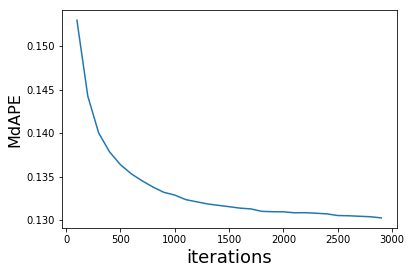

In [18]:
# тут я прогнал тест, чтобы посмотреть, как быстро скорость растёт
# на 3к итераций выходит примерно 13%
# переобучения пока не было
plt.plot([i for i in range (100, 3000, 100)], metrics)
plt.xlabel('iterations', fontsize=18)
plt.ylabel('MdAPE', fontsize=16)
plt.show()